In [2]:
!pip install moval
!pip install seaborn
!pip install pandas
!pip install tqdm
!pip install matplotlib
!pip install seaborn==0.12 # because statannotations not support the latest

In [3]:
import os
import itertools
import zipfile
import pandas as pd
import numpy as np
import moval
import scipy
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from moval.solvers.utils import ComputMetric, ComputAUC
from moval.models.utils import cal_softmax

In [4]:
print(f"The installed MOVAL verision is {moval.__version__}")
print(f"The installed seaborn verision is {sns.__version__}")

The installed MOVAL verision is 0.3.25
The installed seaborn verision is 0.12.0


In [942]:
# ridge plot, using cifar10

In [943]:
def make_ridge_plot_whole(df, mean_conf, acc_all, title = 'Distribution of MCP'):
    """Make the ridge plots for the test case

    Args:
        df: The dataframe which contain all the information.
        mean_conf: mean confidence.
        title: The given title to be shown.

    """
    sns.set(rc={'figure.figsize':(8,1)})
    sns.set_theme(style="white")
    
    ax = sns.kdeplot(data=df, x="Confidence Score", fill=True, alpha=1, linewidth=1.5, color = '#1f77b4', bw_adjust=1)
    sns.kdeplot(data=df, x="Confidence Score", color="w", lw=2, bw_adjust=1)
    #
    ax = plt.gca()
    x, y = ax.lines[0].get_data()
    height = np.interp(mean_conf, x, y)
    ax.axvline(mean_conf, 0.06, 10, color="black", lw=3, alpha=0.7, ls='-')
    #
    # Create a hatched texture fill for the box with gradient color
    gradient_steps = 50  # Number of steps for the gradient
    for i in range(gradient_steps):
        # Calculate the gradient color at this step
        gradient_color = (1 - i / gradient_steps) * np.array([1, 1, 1]) + (i / gradient_steps) * np.array([0x00, 0x00, 0x00]) / 255
        facecolor = tuple(gradient_color)
        
        # Add a rectangle patch for this step
        x_start = (i / gradient_steps) * acc_all
        x_end = ((i + 1) / gradient_steps) * acc_all
        texture_box = patches.Rectangle((x_start, 0), x_end - x_start, 10, linewidth=0, edgecolor='none', facecolor=facecolor, alpha=0.5)
        ax.add_patch(texture_box)
    
    #
    # also pad the differences
    x_left = np.min((mean_conf, acc_all))
    x_right = np.max((mean_conf, acc_all))
    diff_box = patches.Rectangle((x_left, 0), x_right - x_left, 10, linewidth=0, edgecolor='none', facecolor='#A2142F', alpha=0.5)
    ax.add_patch(diff_box)
    
    sns.despine(left=True, bottom=True)
    #
    ax.set(yticks=[], ylabel="")
    ax.set(xticks=[0., 0.2, 0.4, 0.6, 0.8, 1.0], xlabel="")  # Set x-ticks here
    
    plt.xlim(0., 1.0)
    plt.title(title)
    plt.savefig(f'Fig_{title}.pdf', bbox_inches='tight')

In [944]:
def make_ridge_plot(df, mean_conf, cls_acc, height_ratio1, height_ratio2, title = 'Distribution of MCP'):
    """Make the ridge plots for the test case

    Args:
        df: The dataframe which contain all the information.
        mean_conf: A list of ``d`` mean confidence.
        height_ratio: A manual adjust parameter to make sure the mean confidence is within the plot.
        title: The given title to be shown.

    """
    sns.set(rc={'figure.figsize':(8,10)})
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Initialize the FacetGrid object
    g = sns.FacetGrid(df, row="Prediction", hue="Prediction", aspect=12, height=.6)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "Confidence Score",
          fill=True, alpha=1, linewidth=1.5, color = '#1f77b4', bw_adjust=1)
    g.map(sns.kdeplot, "Confidence Score", color="w", lw=2, bw_adjust=1)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=-0.1, linewidth=1, linestyle="-")

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold",
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "Confidence Score")

    # Plot the mean confidence
    def plot_mean(x, color, label):
        ax = plt.gca()
        x, y = ax.lines[0].get_data()
        height = np.interp(mean_conf[np.int32(label)], x, y)
        ax.axvline(mean_conf[np.int32(label)], 0.06, height_ratio1, color="black", lw=3, alpha=0.7, ls='-')
    g.map(plot_mean, "Prediction")
    #
    def plot_acc(x, color, label):
        gradient_steps = 50  # Number of steps for the gradient
        ax = plt.gca()
        acc_all = cls_acc[np.int32(label)]
        for i in range(gradient_steps):
            # Calculate the gradient color at this step
            gradient_color = (1 - i / gradient_steps) * np.array([1, 1, 1]) + (i / gradient_steps) * np.array([0x00, 0x00, 0x00]) / 255
            facecolor = tuple(gradient_color)
            alpha = 0.5  # Constant transparency level for each step
            
            # Add a rectangle patch for this step
            x_start = (i / gradient_steps) * acc_all
            x_end = ((i + 1) / gradient_steps) * acc_all
            texture_box = patches.Rectangle((x_start, 0), x_end - x_start, height_ratio2, linewidth=0, edgecolor='none', facecolor=facecolor, alpha=alpha)
            ax.add_patch(texture_box)
    g.map(plot_acc, "Prediction")
    #
    def plot_err(x, color, label):
        ax = plt.gca()
        acc_all = cls_acc[np.int32(label)]
        _mean_conf = mean_conf[np.int32(label)]
        x_left = np.min((_mean_conf, acc_all))
        x_right = np.max((_mean_conf, acc_all))
        diff_box = patches.Rectangle((x_left, 0), x_right - x_left, height_ratio2, linewidth=0, edgecolor='none', facecolor='#A2142F', alpha=0.5)
        ax.add_patch(diff_box)
            
    g.map(plot_err, "Prediction")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.6)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.set(xticks=[0., 0.2, 0.4, 0.6, 0.8, 1.0], xlabel="")  # Set x-ticks here
    g.set(xlabel="")
    g.despine(bottom=True, left=True)
    #
    plt.suptitle(title, y=0.9)
    # label
    g.fig.text(x=0.03, y=0.5,
           verticalalignment='center', #make sure it's aligned at center vertically
           s='Predicted Class', #this is the text in the ylabel
           size=12, #customize the fontsize if you will
           rotation=90) #vertical text

    # Add legend
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines

    blue_patch = mpatches.Patch(color='#0074b6', edgecolor=None, label='Confidence\nScore')
    orange_patch = mpatches.Patch(color='black', alpha=0.7, edgecolor=None, label='Accuracy')
    red_patch = mpatches.Patch(color='#A2142F', alpha=0.7, edgecolor=None, label='Estimation\nGap')
    black_line = mlines.Line2D([0.5, 0.5], [0, 1], color='black', lw=3, alpha=0.7, label='Mean\nConfidence')

    plt.xlim(0., 1.0)
    legend = plt.legend(handles=[orange_patch, blue_patch, black_line, red_patch],
               bbox_to_anchor=(0.5, -0.6),  # Centered below the plot
               loc='center',                # Center horizontally
               facecolor='white',
               ncol=4)                      # Arrange items in a single row

    # Center-align the text in the legend
    for text in legend.get_texts():
        text.set_ha('center')
    plt.savefig(f'Fig_{title}.pdf', bbox_inches='tight')

In [945]:
# validation dataset
val_data = "/well/win-fmrib-analysis/users/gqu790/moval/Robust-Skin-Lesion-Classification/cifar10results/baseline/predictions_val.csv"
# test dataset
test_data = "/well/win-fmrib-analysis/users/gqu790/moval/Robust-Skin-Lesion-Classification/cifar10results/baseline/predictions_val_contrast.csv"
#
cnn_pred = pd.read_csv(val_data)
targets_all = np.array(cnn_pred[['target_0', 'target_1', 'target_2', 'target_3', 'target_4',
                                 'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits = np.array(cnn_pred[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4',
                               'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt = np.argmax(targets_all, axis = 1)
#
cnn_pred_test = pd.read_csv(test_data)
targets_all_test = np.array(cnn_pred_test[['target_0', 'target_1', 'target_2', 'target_3', 'target_4',
                                           'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits_test = np.array(cnn_pred_test[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4',
                                      'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt_test = np.argmax(targets_all_test, axis = 1)

In [946]:
# MCP | AC
dataset = "CIFAR10"
mode = "classification"
metric = "accuracy"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ac-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"

In [947]:
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
pred_val = np.argmax(logits, axis = 1)
real_metric_val = np.sum(gt == pred_val) / len(gt)
#
conf_val = moval_model.model_.calibrate(logits)
#
d = {'Confidence Score': conf_val,
         'ID': range(len(conf_val)),
         'Ground Truth': gt,
         'Prediction': np.argmax(logits, axis=1),
         'Correctness': gt == np.argmax(logits, axis=1)}
df = pd.DataFrame(data=d)

In [948]:
mean_conf = []
cls_acc = []
acc_all = np.sum(gt == np.argmax(logits, axis = 1)) / len(np.argmax(logits, axis = 1))
for k_cls in range(logits.shape[1]):

    k_pos = np.where(np.argmax(logits, axis=1) == k_cls)[0]
    #
    _logits = logits[k_pos, :]
    _gt = gt[k_pos]
    _conf = conf_val[k_pos]
    #
    mean_conf.append(np.mean(_conf))
    #
    acc = np.sum(_gt == np.argmax(_logits, axis = 1)) / len(np.argmax(_logits, axis = 1))
    cls_acc.append(acc)

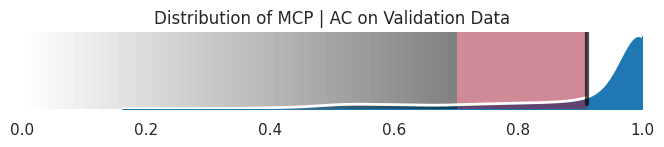

In [949]:
make_ridge_plot_whole(df, np.mean(conf_val), acc_all, title = "Distribution of MCP | AC on Validation Data")
plt.show()

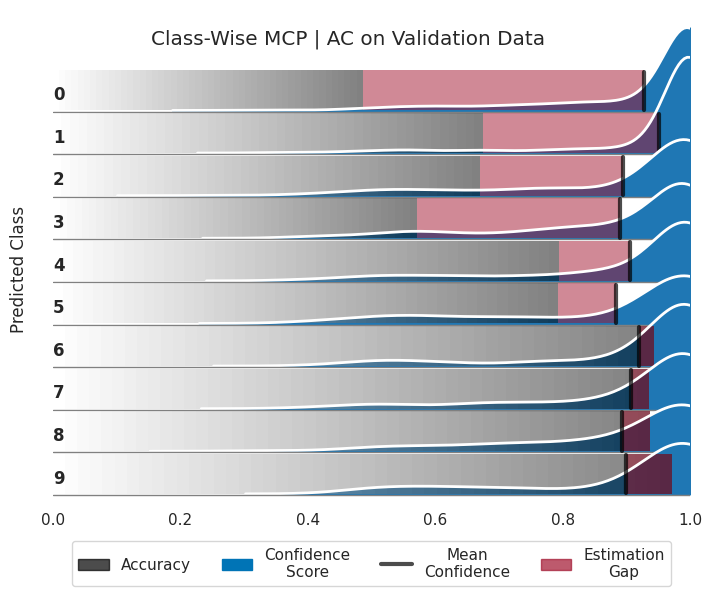

In [950]:
make_ridge_plot(df, mean_conf, cls_acc, height_ratio1 = 0.42, height_ratio2 = 3.7, title = 'Class-Wise MCP | AC on Validation Data')
plt.show()

In [951]:
estim_metric_test = moval_model.estimate(logits_test)
#
pred_test = np.argmax(logits_test, axis = 1)
real_metric_test = np.sum(gt_test == pred_test) / len(gt_test)
#
conf_test = moval_model.model_.calibrate(logits_test)
#
d = {'Confidence Score': conf_test,
         'ID': range(len(conf_test)),
         'Ground Truth': gt_test,
         'Prediction': np.argmax(logits_test, axis=1),
         'Correctness': gt_test == np.argmax(logits_test, axis=1)}
df = pd.DataFrame(data=d)

In [952]:
mean_conf = []
cls_acc = []
acc_all = np.sum(gt_test == np.argmax(logits_test, axis = 1)) / len(np.argmax(logits_test, axis = 1))
for k_cls in range(logits_test.shape[1]):

    k_pos = np.where(np.argmax(logits_test, axis=1) == k_cls)[0]
    #
    _logits = logits_test[k_pos, :]
    _gt = gt_test[k_pos]
    _conf = conf_test[k_pos]
    #
    mean_conf.append(np.mean(_conf))
    #
    acc = np.sum(_gt == np.argmax(_logits, axis = 1)) / len(np.argmax(_logits, axis = 1))
    cls_acc.append(acc)

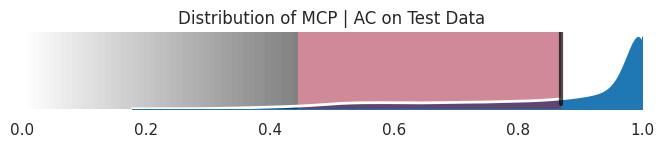

In [953]:
make_ridge_plot_whole(df, np.mean(conf_test), acc_all, title = "Distribution of MCP | AC on Test Data")
plt.show()

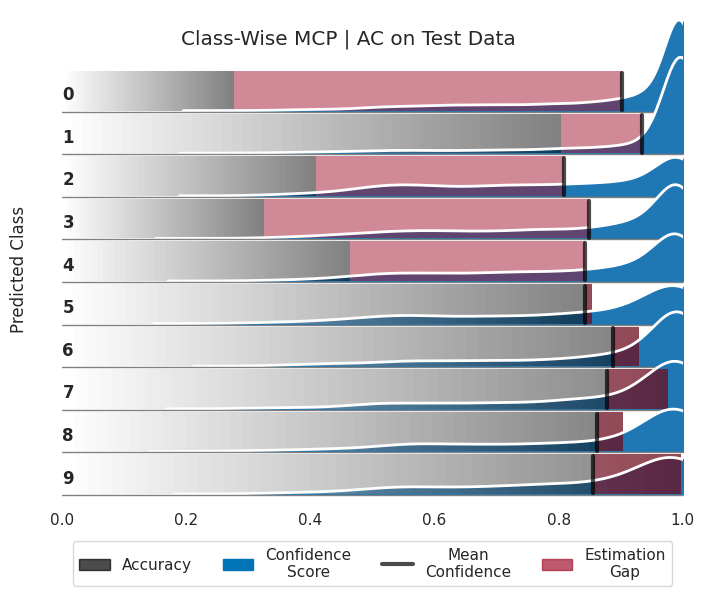

In [954]:
make_ridge_plot(df, mean_conf, cls_acc, height_ratio1 = 0.41, height_ratio2 = 4.3, title = 'Class-Wise MCP | AC on Test Data')
plt.show()

In [955]:
# MCP | TS
dataset = "CIFAR10"
mode = "classification"
metric = "accuracy"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"

In [956]:
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
pred_val = np.argmax(logits, axis = 1)
real_metric_val = np.sum(gt == pred_val) / len(gt)
#
conf_val = moval_model.model_.calibrate(logits)
#
d = {'Confidence Score': conf_val,
         'ID': range(len(conf_val)),
         'Ground Truth': gt,
         'Prediction': np.argmax(logits, axis=1),
         'Correctness': gt == np.argmax(logits, axis=1)}
df = pd.DataFrame(data=d)

In [957]:
mean_conf = []
cls_acc = []
acc_all = np.sum(gt == np.argmax(logits, axis = 1)) / len(np.argmax(logits, axis = 1))
for k_cls in range(logits.shape[1]):

    k_pos = np.where(np.argmax(logits, axis=1) == k_cls)[0]
    #
    _logits = logits[k_pos, :]
    _gt = gt[k_pos]
    _conf = conf_val[k_pos]
    #
    mean_conf.append(np.mean(_conf))
    #
    acc = np.sum(_gt == np.argmax(_logits, axis = 1)) / len(np.argmax(_logits, axis = 1))
    cls_acc.append(acc)

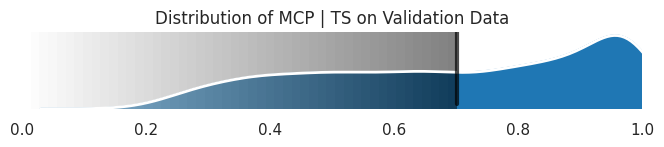

In [958]:
make_ridge_plot_whole(df, np.mean(conf_val), acc_all, title = "Distribution of MCP | TS on Validation Data")
plt.show()

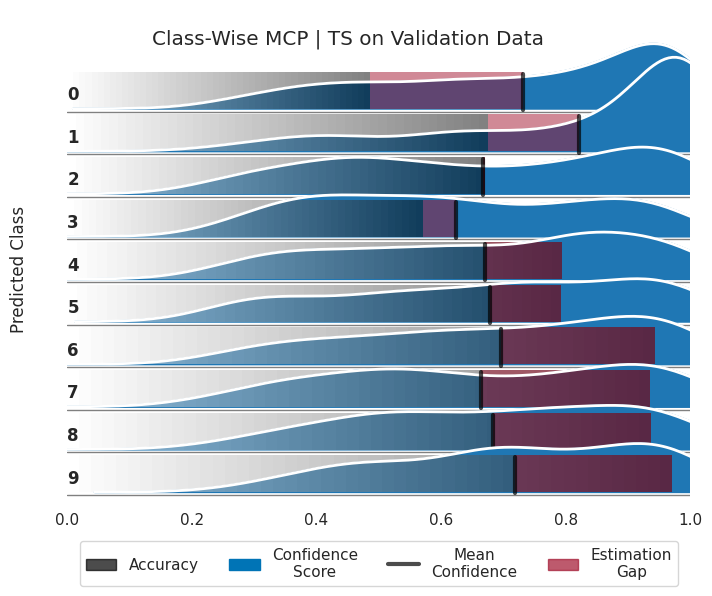

In [959]:
make_ridge_plot(df, mean_conf, cls_acc, height_ratio1 = 0.4, height_ratio2 = 1.3, title = 'Class-Wise MCP | TS on Validation Data')
plt.show()

In [960]:
estim_metric_test = moval_model.estimate(logits_test)
#
pred_test = np.argmax(logits_test, axis = 1)
real_metric_test = np.sum(gt_test == pred_test) / len(gt_test)
#
conf_test = moval_model.model_.calibrate(logits_test)
#
d = {'Confidence Score': conf_test,
         'ID': range(len(conf_test)),
         'Ground Truth': gt_test,
         'Prediction': np.argmax(logits_test, axis=1),
         'Correctness': gt_test == np.argmax(logits_test, axis=1)}
df = pd.DataFrame(data=d)

In [961]:
mean_conf = []
cls_acc = []
acc_all = np.sum(gt_test == np.argmax(logits_test, axis = 1)) / len(np.argmax(logits_test, axis = 1))
for k_cls in range(logits_test.shape[1]):

    k_pos = np.where(np.argmax(logits_test, axis=1) == k_cls)[0]
    #
    _logits = logits_test[k_pos, :]
    _gt = gt_test[k_pos]
    _conf = conf_test[k_pos]
    #
    mean_conf.append(np.mean(_conf))
    #
    acc = np.sum(_gt == np.argmax(_logits, axis = 1)) / len(np.argmax(_logits, axis = 1))
    cls_acc.append(acc)

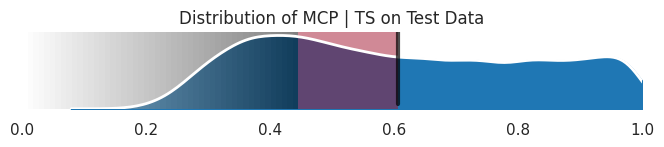

In [962]:
make_ridge_plot_whole(df, np.mean(conf_test), acc_all, title = "Distribution of MCP | TS on Test Data")
plt.show()

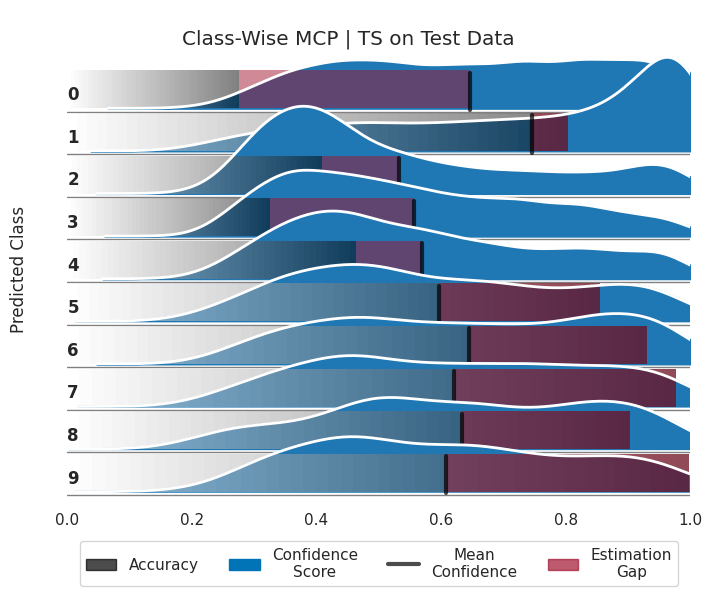

In [963]:
make_ridge_plot(df, mean_conf, cls_acc, height_ratio1 = 0.41, height_ratio2 = 1.18, title = 'Class-Wise MCP | TS on Test Data')
plt.show()

In [1062]:
# MCP | CS TS
dataset = "CIFAR10"
mode = "classification"
metric = "accuracy"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = True
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"

In [1063]:
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
pred_val = np.argmax(logits, axis = 1)
real_metric_val = np.sum(gt == pred_val) / len(gt)
#
conf_val = moval_model.model_.calibrate(logits)
#
d = {'Confidence Score': conf_val,
         'ID': range(len(conf_val)),
         'Ground Truth': gt,
         'Prediction': np.argmax(logits, axis=1),
         'Correctness': gt == np.argmax(logits, axis=1)}
df = pd.DataFrame(data=d)

In [1064]:
mean_conf = []
cls_acc = []
acc_all = np.sum(gt == np.argmax(logits, axis = 1)) / len(np.argmax(logits, axis = 1))
for k_cls in range(logits.shape[1]):

    k_pos = np.where(np.argmax(logits, axis=1) == k_cls)[0]
    #
    _logits = logits[k_pos, :]
    _gt = gt[k_pos]
    _conf = conf_val[k_pos]
    #
    mean_conf.append(np.mean(_conf))
    #
    acc = np.sum(_gt == np.argmax(_logits, axis = 1)) / len(np.argmax(_logits, axis = 1))
    cls_acc.append(acc)

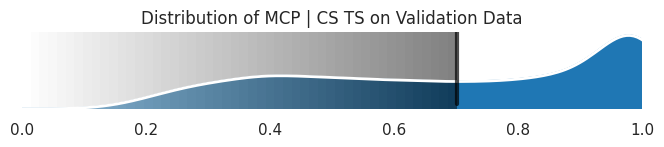

In [991]:
make_ridge_plot_whole(df, np.mean(conf_val), acc_all, title = "Distribution of MCP | CS TS on Validation Data")
plt.show()

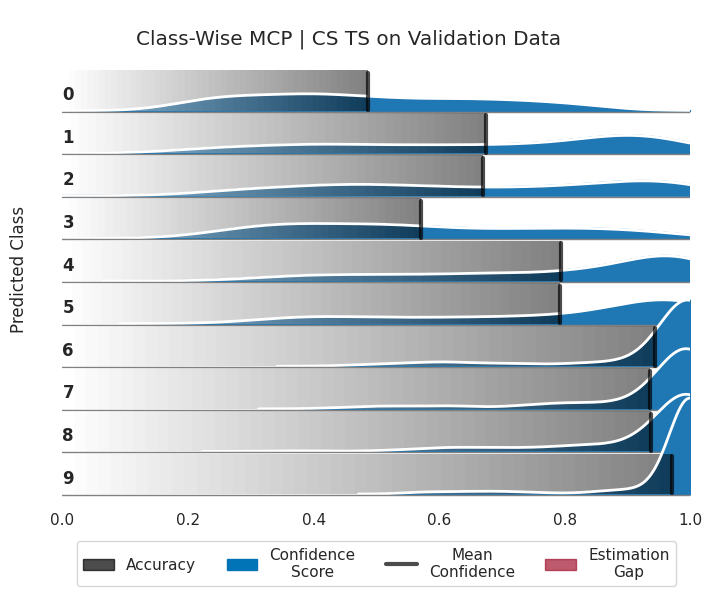

In [992]:
make_ridge_plot(df, mean_conf, cls_acc, height_ratio1 = 0.41, height_ratio2 = 4.5, title = 'Class-Wise MCP | CS TS on Validation Data')
plt.show()

In [1065]:
estim_metric_test = moval_model.estimate(logits_test)
#
pred_test = np.argmax(logits_test, axis = 1)
real_metric_test = np.sum(gt_test == pred_test) / len(gt_test)
#
conf_test = moval_model.model_.calibrate(logits_test)
#
d = {'Confidence Score': conf_test,
         'ID': range(len(conf_test)),
         'Ground Truth': gt_test,
         'Prediction': np.argmax(logits_test, axis=1),
         'Correctness': gt_test == np.argmax(logits_test, axis=1)}
df = pd.DataFrame(data=d)

In [1066]:
mean_conf = []
cls_acc = []
acc_all = np.sum(gt_test == np.argmax(logits_test, axis = 1)) / len(np.argmax(logits_test, axis = 1))
for k_cls in range(logits_test.shape[1]):

    k_pos = np.where(np.argmax(logits_test, axis=1) == k_cls)[0]
    #
    _logits = logits_test[k_pos, :]
    _gt = gt_test[k_pos]
    _conf = conf_test[k_pos]
    #
    mean_conf.append(np.mean(_conf))
    #
    acc = np.sum(_gt == np.argmax(_logits, axis = 1)) / len(np.argmax(_logits, axis = 1))
    cls_acc.append(acc)

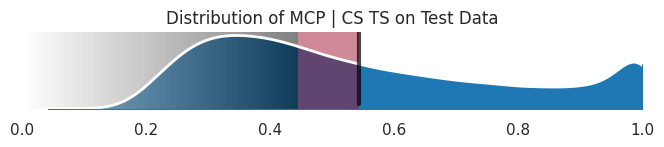

In [995]:
make_ridge_plot_whole(df, np.mean(conf_test), acc_all, title = "Distribution of MCP | CS TS on Test Data")
plt.show()

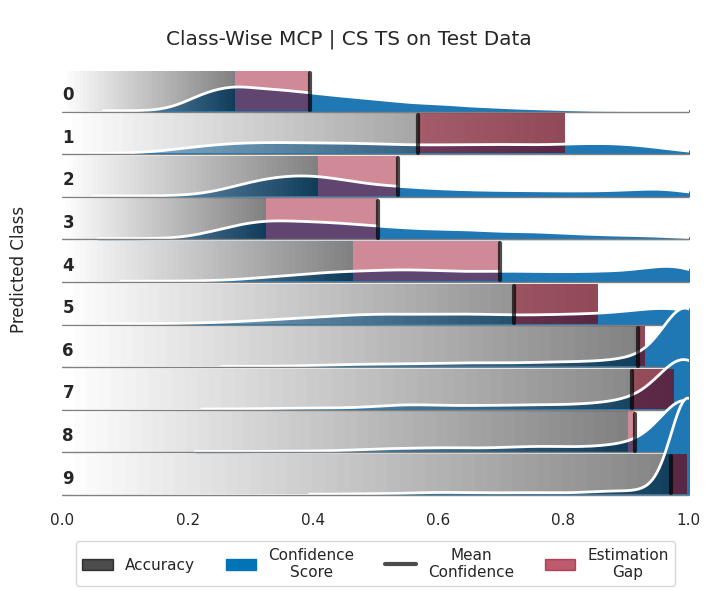

In [996]:
make_ridge_plot(df, mean_conf, cls_acc, height_ratio1 = 0.41, height_ratio2 = 5.4, title = 'Class-Wise MCP | CS TS on Test Data')
plt.show()

In [1040]:
# MOVAL Ensemble
dataset = "CIFAR10"
mode = "classification"
metric = "accuracy"
estim_algorithm = "moval-ensemble-cls-accuracy"
ckpt_savname = f"./{dataset}_{mode}_{metric}_{estim_algorithm}.pkl"

In [974]:
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
pred_val = np.argmax(logits, axis = 1)
real_metric_val = np.sum(gt == pred_val) / len(gt)
#
conf_val_0 = moval_model.model_[0].calibrate(logits)
conf_val_1 = moval_model.model_[1].calibrate(logits)
conf_val_2 = moval_model.model_[2].calibrate(logits)
conf_val = np.mean(np.stack((conf_val_0, conf_val_1, conf_val_2)), axis = 0)
#
d = {'Confidence Score': conf_val,
         'ID': range(len(conf_val)),
         'Ground Truth': gt,
         'Prediction': np.argmax(logits, axis=1),
         'Correctness': gt == np.argmax(logits, axis=1)}
df = pd.DataFrame(data=d)

In [975]:
mean_conf = []
cls_acc = []
acc_all = np.sum(gt == np.argmax(logits, axis = 1)) / len(np.argmax(logits, axis = 1))
for k_cls in range(logits.shape[1]):

    k_pos = np.where(np.argmax(logits, axis=1) == k_cls)[0]
    #
    _logits = logits[k_pos, :]
    _gt = gt[k_pos]
    _conf = conf_val[k_pos]
    #
    mean_conf.append(np.mean(_conf))
    #
    acc = np.sum(_gt == np.argmax(_logits, axis = 1)) / len(np.argmax(_logits, axis = 1))
    cls_acc.append(acc)

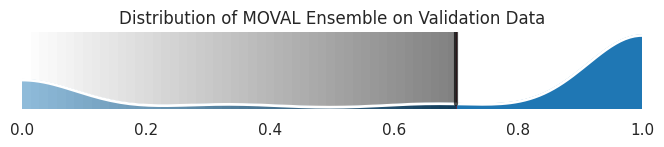

In [976]:
make_ridge_plot_whole(df, np.mean(conf_val), acc_all, title = "Distribution of MOVAL Ensemble on Validation Data")
plt.show()

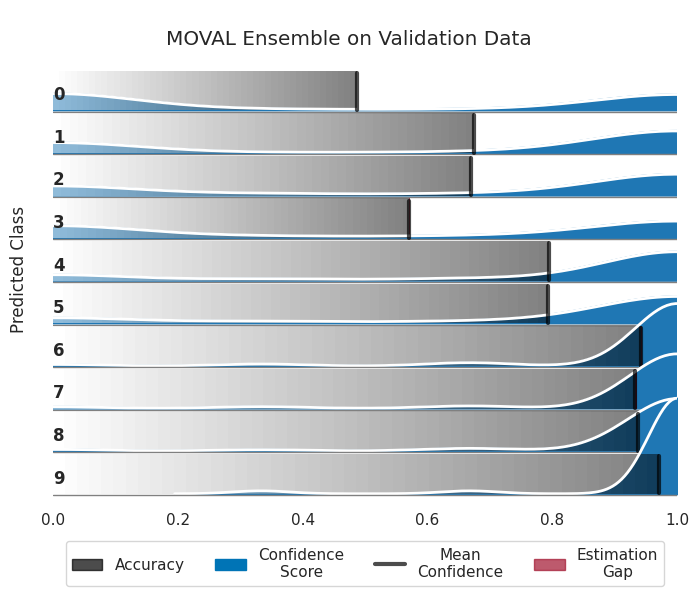

In [977]:
make_ridge_plot(df, mean_conf, cls_acc, height_ratio1 = 0.41, height_ratio2 = 3.4, title = 'MOVAL Ensemble on Validation Data')
plt.show()

In [978]:
estim_metric_test = moval_model.estimate(logits_test)
#
pred_test = np.argmax(logits_test, axis = 1)
real_metric_test = np.sum(gt_test == pred_test) / len(gt_test)
#
conf_test_0 = moval_model.model_[0].calibrate(logits_test)
conf_test_1 = moval_model.model_[1].calibrate(logits_test)
conf_test_2 = moval_model.model_[2].calibrate(logits_test)
conf_test = np.mean(np.stack((conf_test_0, conf_test_1, conf_test_2)), axis = 0)
#
d = {'Confidence Score': conf_test,
         'ID': range(len(conf_test)),
         'Ground Truth': gt_test,
         'Prediction': np.argmax(logits_test, axis=1),
         'Correctness': gt_test == np.argmax(logits_test, axis=1)}
df = pd.DataFrame(data=d)

In [979]:
mean_conf = []
cls_acc = []
acc_all = np.sum(gt_test == np.argmax(logits_test, axis = 1)) / len(np.argmax(logits_test, axis = 1))
for k_cls in range(logits_test.shape[1]):

    k_pos = np.where(np.argmax(logits_test, axis=1) == k_cls)[0]
    #
    _logits = logits_test[k_pos, :]
    _gt = gt_test[k_pos]
    _conf = conf_test[k_pos]
    #
    mean_conf.append(np.mean(_conf))
    #
    acc = np.sum(_gt == np.argmax(_logits, axis = 1)) / len(np.argmax(_logits, axis = 1))
    cls_acc.append(acc)

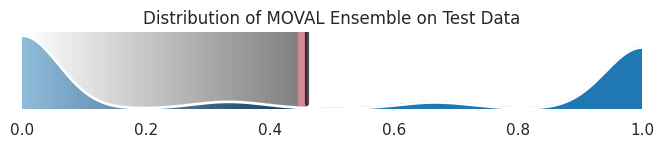

In [980]:
make_ridge_plot_whole(df, np.mean(conf_test), acc_all, title = "Distribution of MOVAL Ensemble on Test Data")
plt.show()

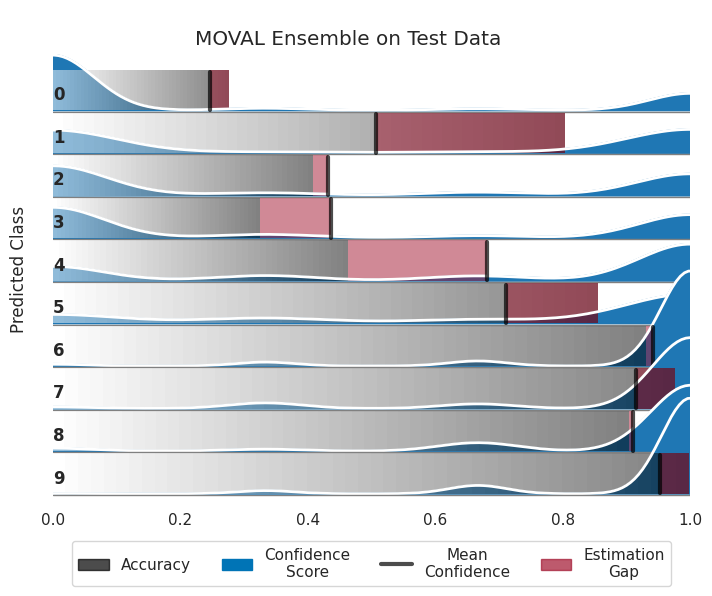

In [981]:
make_ridge_plot(df, mean_conf, cls_acc, height_ratio1 = 0.42, height_ratio2 = 3.3, title = 'MOVAL Ensemble on Test Data')
plt.show()

In [1124]:
# performance tracking plot

In [1125]:
# validation dataset
val_data = "/well/win-fmrib-analysis/users/gqu790/moval/Robust-Skin-Lesion-Classification/cifar10results/baseline/predictions_val.csv"
# test dataset
test_data = "/well/win-fmrib-analysis/users/gqu790/moval/Robust-Skin-Lesion-Classification/cifar10results/baseline/predictions_val_fog.csv"
#
cnn_pred = pd.read_csv(val_data)
targets_all = np.array(cnn_pred[['target_0', 'target_1', 'target_2', 'target_3', 'target_4',
                                 'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits = np.array(cnn_pred[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4',
                               'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt = np.argmax(targets_all, axis = 1)
#
cnn_pred_test = pd.read_csv(test_data)
targets_all_test = np.array(cnn_pred_test[['target_0', 'target_1', 'target_2', 'target_3', 'target_4',
                                           'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits_test = np.array(cnn_pred_test[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4',
                                      'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt_test = np.argmax(targets_all_test, axis = 1)
pred_test = np.argmax(logits_test, axis = 1)

In [1126]:
# MCP | CS TS
dataset = "CIFAR10"
mode = "classification"
metric = "accuracy"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = True
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"

In [1127]:
_conf_test = moval_model.model_.calibrate(logits_test)[:3500]
perf = moval_model.fitted_perf

In [1131]:
# validation dataset
val_data = "/well/win-fmrib-analysis/users/gqu790/moval/Robust-Skin-Lesion-Classification/cifar10results/baseline/predictions_val.csv"
# test dataset
test_data = "/well/win-fmrib-analysis/users/gqu790/moval/Robust-Skin-Lesion-Classification/cifar10results/baseline/predictions_val_zoom_blur.csv"
#
cnn_pred = pd.read_csv(val_data)
targets_all = np.array(cnn_pred[['target_0', 'target_1', 'target_2', 'target_3', 'target_4',
                                 'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits = np.array(cnn_pred[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4',
                               'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt = np.argmax(targets_all, axis = 1)
#
cnn_pred_test = pd.read_csv(test_data)
targets_all_test = np.array(cnn_pred_test[['target_0', 'target_1', 'target_2', 'target_3', 'target_4',
                                           'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits_test = np.array(cnn_pred_test[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4',
                                      'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt_test = np.argmax(targets_all_test, axis = 1)
pred_test = np.argmax(logits_test, axis = 1)

In [1132]:
__conf_test = moval_model.model_.calibrate(logits_test)[:3500]

In [1133]:
np.mean(_conf_test)

0.6241771621665002

In [1134]:
np.mean(__conf_test)

0.5645257599910033

In [1136]:
np.mean(perf)

0.7013333307018705

/tmp/ipykernel_27863/2035443679.py:49: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._alpha = 1  # Set marker size for the scatter plots in the legend
/tmp/ipykernel_27863/2035443679.py:50: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1]._alpha = 1


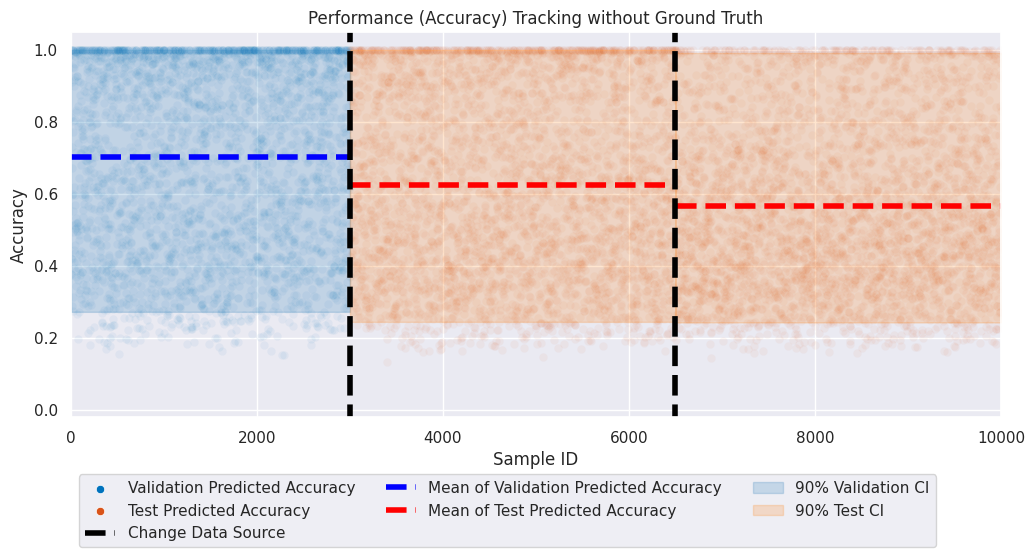

In [1165]:
sns.set(rc={'figure.figsize':(12,5)})
sns.set_theme(style="darkgrid")

ax = sns.scatterplot(x=range(len(perf)), y=perf, alpha=0.05,label='Validation Predicted Accuracy', color = '#0072BD')

ax = sns.scatterplot(x=range(len(perf), len(perf)+len(_conf_test)), y=_conf_test, alpha=0.05,label='Test Predicted Accuracy', color='#D95319')

ax = sns.scatterplot(x=range(len(perf)+len(_conf_test), len(perf)+len(_conf_test)+len(__conf_test)), y=__conf_test, alpha=0.05, color='#D95319')

# Calculate the 5th and 95th percentiles
percentiles = np.percentile(perf, [5, 95])

# Shade the area between the 5th and 95th percentiles
plt.fill_between(x=range(len(perf)), y1=percentiles[0], y2=percentiles[1], color='#1f77b4', alpha=0.2, label='90% Validation CI')
# Calculate the mean of the data
mean_value = sum(perf) / len(perf)

# Draw a horizontal line at the mean
plt.axhline(y = mean_value, color='blue', linestyle='--', label='Mean of Validation Predicted Accuracy', xmin=0, xmax=(len(perf) - 1) / (len(perf) + len(_conf_test) + len(__conf_test) - 1), lw=4)

mean_value_new = sum(_conf_test) / len(_conf_test)
# Draw a horizontal line at the mean
plt.axhline(y = mean_value_new, color='red', linestyle='--', label='Mean of Test Predicted Accuracy', xmin=len(perf) / (len(perf) + len(_conf_test)+ len(__conf_test) - 1), xmax=(len(perf) + len(_conf_test)) / (len(perf) + len(_conf_test)+ len(__conf_test) - 1), lw=4)

_mean_value_new = sum(__conf_test) / len(__conf_test)
# Draw a horizontal line at the mean
plt.axhline(y = _mean_value_new, color='red', linestyle='--', xmin=(len(perf) + len(_conf_test)) / (len(perf) + len(_conf_test)+ len(__conf_test) - 1), xmax=1, lw=4)


percentiles = np.percentile(_conf_test, [5, 95])
# Shade the area between the 5th and 95th percentiles
plt.fill_between(x=range(len(perf), len(perf)+len(_conf_test)), y1=percentiles[0], y2=percentiles[1], color='#ff7f0e', alpha=0.2, label='90% Test CI')

percentiles = np.percentile(__conf_test, [5, 95])
plt.fill_between(x=range(len(perf)+len(_conf_test), len(perf)+len(_conf_test)+len(__conf_test)), y1=percentiles[0], y2=percentiles[1], color='#ff7f0e', alpha=0.2)

ax.set(ylim=(-0.02, 1.05))
ax.set(xlim=(0, len(perf)+len(_conf_test)++len(__conf_test)))

ymin, ymax = plt.ylim()

plt.axvline(x=len(perf) - 1,ymin=ymin, ymax=ymax, color='black', linestyle='--', label='Change Data Source', lw=4)
plt.axvline(x=len(perf)+len(_conf_test) - 1,ymin=ymin, ymax=ymax, color='black', linestyle='--', label='Change Data Source', lw=4)

# Show the legend for both scatter plots and lines without alpha
handles, labels = ax.get_legend_handles_labels()
order = [0, 1, 6, 3, 4, 2, 5]
legend = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
legend.legendHandles[0]._alpha = 1  # Set marker size for the scatter plots in the legend
legend.legendHandles[1]._alpha = 1
sns.move_legend(ax, "upper left", bbox_to_anchor=(0., -0.13), ncol=3)

# Set x and y labels
plt.xlabel('Sample ID')
plt.ylabel('Accuracy')

plt.title('Performance (Accuracy) Tracking without Ground Truth')
plt.savefig(f'Fig_perf_track.pdf', bbox_inches='tight')

In [1164]:
# show the illustration of other metrics

In [1000]:
# validation dataset
val_data = "/well/win-fmrib-analysis/users/gqu790/moval/Robust-Skin-Lesion-Classification/cifar10results/baseline/predictions_val.csv"
# test dataset
test_data = "/well/win-fmrib-analysis/users/gqu790/moval/Robust-Skin-Lesion-Classification/cifar10results/baseline/predictions_val_spatter.csv"
#
cnn_pred = pd.read_csv(val_data)
targets_all = np.array(cnn_pred[['target_0', 'target_1', 'target_2', 'target_3', 'target_4',
                                 'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits = np.array(cnn_pred[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4',
                               'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt = np.argmax(targets_all, axis = 1)
#
cnn_pred_test = pd.read_csv(test_data)
targets_all_test = np.array(cnn_pred_test[['target_0', 'target_1', 'target_2', 'target_3', 'target_4',
                                           'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits_test = np.array(cnn_pred_test[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4',
                                      'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt_test = np.argmax(targets_all_test, axis = 1)
pred_test = np.argmax(logits_test, axis = 1)

In [1010]:
# MCP | AC
dataset = "CIFAR10"
mode = "classification"
metric = "f1score"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ac-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
real_F1scores = []
for kcls in range(logits.shape[1]):
    real_F1score, _, _ = ComputMetric(gt == kcls, pred_val == kcls)
    real_F1scores.append(real_F1score)
real_metric_val = real_F1scores
#
estim_err_mcp = (estim_metric_val - real_metric_val) * 100
# MCP | TS
dataset = "CIFAR10"
mode = "classification"
metric = "f1score"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
real_F1scores = []
for kcls in range(logits.shape[1]):
    real_F1score, _, _ = ComputMetric(gt == kcls, pred_val == kcls)
    real_F1scores.append(real_F1score)
real_metric_val = real_F1scores
#
estim_err_ts = (estim_metric_val - real_metric_val) * 100
# MCP | CS TS
dataset = "CIFAR10"
mode = "classification"
metric = "f1score"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = True
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
real_F1scores = []
for kcls in range(logits.shape[1]):
    real_F1score, _, _ = ComputMetric(gt == kcls, pred_val == kcls)
    real_F1scores.append(real_F1score)
real_metric_val = real_F1scores
#
estim_err_csts = (estim_metric_val - real_metric_val) * 100

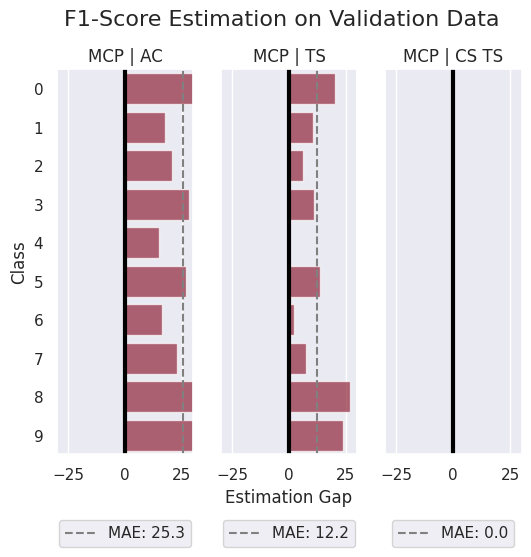

In [1011]:
fig, axs = plt.subplots(1, 3, figsize=(6, 5))  # Adjust figsize as needed
sns.set_theme(style="darkgrid")
#
sns.barplot(ax =axs[0],  x=estim_err_mcp, y=np.arange(len(estim_err_mcp)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[0].set_xlabel('')
# Add y-axis label
axs[0].set_ylabel('Class')
axs[0].set_title('MCP | AC')
mean_estim_err = np.mean(np.abs(estim_err_mcp))
axs[0].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[0].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[0].set_xlim(-30, 30)  # Adjust the range as needed
#
sns.barplot(ax =axs[1],  x=estim_err_ts, y=np.arange(len(estim_err_ts)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[1].set_xlabel('Estimation Gap')
# Add y-axis label
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('MCP | TS')
mean_estim_err = np.mean(np.abs(estim_err_ts))
axs[1].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[1].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[1].set_xlim(-30, 30)  # Adjust the range as needed
#
sns.barplot(ax =axs[2],  x=estim_err_csts, y=np.arange(len(estim_err_csts)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[2].set_xlabel('')
# Add y-axis label
axs[2].set_yticks([])
axs[2].set_ylabel('')
axs[2].set_title('MCP | CS TS')
mean_estim_err = np.mean(np.abs(estim_err_csts))
axs[2].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[2].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[2].set_xlim(-30, 30)  # Adjust the range as needed
#
fig.suptitle('F1-Score Estimation on Validation Data', fontsize=16, y=1.0)  # Adjust fontsize and y position as needed
plt.savefig(f'Fig_f1_val.pdf', bbox_inches='tight')
plt.show()

In [1003]:
# MCP | AC
dataset = "CIFAR10"
mode = "classification"
metric = "f1score"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ac-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
real_F1scores = []
for kcls in range(logits.shape[1]):
    real_F1score, _, _ = ComputMetric(gt_test == kcls, pred_test == kcls)
    real_F1scores.append(real_F1score)
real_metric_test = real_F1scores
#
estim_err_mcp_test = (estim_metric_test - real_metric_test) * 100
# MCP | TS
dataset = "CIFAR10"
mode = "classification"
metric = "f1score"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
estim_err_ts_test = (estim_metric_test - real_metric_test) * 100
# MCP | CS TS
dataset = "CIFAR10"
mode = "classification"
metric = "f1score"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = True
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
estim_err_csts_test = (estim_metric_test - real_metric_test) * 100

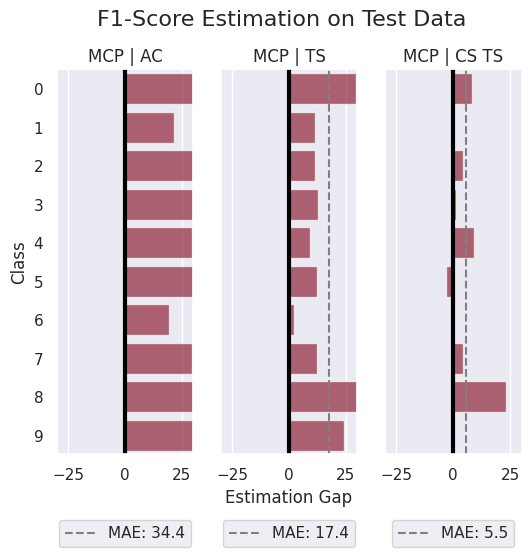

In [1004]:
fig, axs = plt.subplots(1, 3, figsize=(6, 5))  # Adjust figsize as needed
sns.set_theme(style="darkgrid")
#
sns.barplot(ax =axs[0],  x=estim_err_mcp_test, y=np.arange(len(estim_err_mcp_test)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[0].set_xlabel('')
# Add y-axis label
axs[0].set_ylabel('Class')
axs[0].set_title('MCP | AC')
mean_estim_err = np.mean(np.abs(estim_err_mcp_test))
axs[0].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[0].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[0].set_xlim(-30, 30)  # Adjust the range as needed
#
sns.barplot(ax =axs[1],  x=estim_err_ts_test, y=np.arange(len(estim_err_ts_test)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[1].set_xlabel('Estimation Gap')
# Add y-axis label
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('MCP | TS')
mean_estim_err = np.mean(np.abs(estim_err_ts_test))
axs[1].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[1].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[1].set_xlim(-30, 30)  # Adjust the range as needed
#
sns.barplot(ax =axs[2],  x=estim_err_csts_test, y=np.arange(len(estim_err_csts_test)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[2].set_xlabel('')
# Add y-axis label
axs[2].set_yticks([])
axs[2].set_ylabel('')
axs[2].set_title('MCP | CS TS')
mean_estim_err = np.mean(np.abs(estim_err_csts_test))
axs[2].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[2].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[2].set_xlim(-30, 30)  # Adjust the range as needed
#
fig.suptitle('F1-Score Estimation on Test Data', fontsize=16, y=1.0)  # Adjust fontsize and y position as needed
plt.savefig(f'Fig_f1_test.pdf', bbox_inches='tight')
plt.show()

In [50]:
# Sensitivitty

In [51]:
# MCP | AC
dataset = "CIFAR10"
mode = "classification"
metric = "sensitivity"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ac-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
real_F1scores = []
for kcls in range(logits.shape[1]):
    _, real_Sensitivity, _ = ComputMetric(gt == kcls, pred_val == kcls)
    real_F1scores.append(real_Sensitivity)
real_metric_val = real_F1scores
#
estim_err_mcp = (estim_metric_val - real_metric_val) * 100
# MCP | TS
dataset = "CIFAR10"
mode = "classification"
metric = "sensitivity"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
estim_err_ts = (estim_metric_val - real_metric_val) * 100
# MCP | CS TS
dataset = "CIFAR10"
mode = "classification"
metric = "sensitivity"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = True
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
estim_err_csts = (estim_metric_val - real_metric_val) * 100

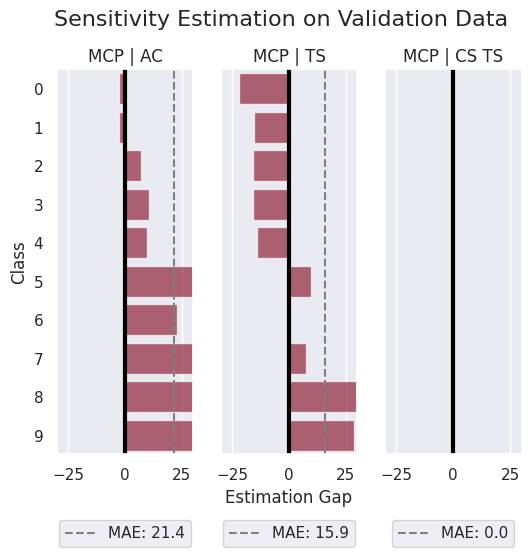

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(6, 5))  # Adjust figsize as needed
sns.set_theme(style="darkgrid")
#
sns.barplot(ax =axs[0],  x=estim_err_mcp, y=np.arange(len(estim_err_mcp)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[0].set_xlabel('')
# Add y-axis label
axs[0].set_ylabel('Class')
axs[0].set_title('MCP | AC')
mean_estim_err = np.mean(np.abs(estim_err_mcp))
axs[0].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[0].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[0].set_xlim(-30, 30)  # Adjust the range as needed
#
sns.barplot(ax =axs[1],  x=estim_err_ts, y=np.arange(len(estim_err_ts)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[1].set_xlabel('Estimation Gap')
# Add y-axis label
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('MCP | TS')
mean_estim_err = np.mean(np.abs(estim_err_ts))
axs[1].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[1].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[1].set_xlim(-30, 30)  # Adjust the range as needed
#
sns.barplot(ax =axs[2],  x=estim_err_csts, y=np.arange(len(estim_err_csts)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[2].set_xlabel('')
# Add y-axis label
axs[2].set_yticks([])
axs[2].set_ylabel('')
axs[2].set_title('MCP | CS TS')
mean_estim_err = np.mean(np.abs(estim_err_csts))
axs[2].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[2].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[2].set_xlim(-30, 30)  # Adjust the range as needed
#
fig.suptitle('Sensitivity Estimation on Validation Data', fontsize=16, y=1.0)  # Adjust fontsize and y position as needed
plt.savefig(f'Fig_sens_val.pdf', bbox_inches='tight')
plt.show()

In [53]:
# MCP | AC
dataset = "CIFAR10"
mode = "classification"
metric = "sensitivity"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ac-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
real_F1scores = []
for kcls in range(logits.shape[1]):
    _, real_Sensitivity, _ = ComputMetric(gt_test == kcls, pred_test == kcls)
    real_F1scores.append(real_Sensitivity)
real_metric_test = real_F1scores
#
estim_err_mcp_test = (estim_metric_test - real_metric_test) * 100
# MCP | TS
dataset = "CIFAR10"
mode = "classification"
metric = "sensitivity"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
estim_err_ts_test = (estim_metric_test - real_metric_test) * 100
# MCP | CS TS
dataset = "CIFAR10"
mode = "classification"
metric = "sensitivity"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = True
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
estim_err_csts_test = (estim_metric_test - real_metric_test) * 100

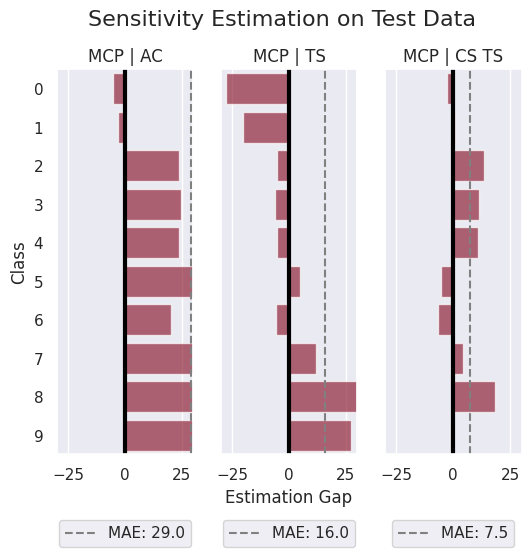

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(6, 5))  # Adjust figsize as needed
sns.set_theme(style="darkgrid")
#
sns.barplot(ax =axs[0],  x=estim_err_mcp_test, y=np.arange(len(estim_err_mcp_test)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[0].set_xlabel('')
# Add y-axis label
axs[0].set_ylabel('Class')
axs[0].set_title('MCP | AC')
mean_estim_err = np.mean(np.abs(estim_err_mcp_test))
axs[0].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[0].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[0].set_xlim(-30, 30)  # Adjust the range as needed
#
sns.barplot(ax =axs[1],  x=estim_err_ts_test, y=np.arange(len(estim_err_ts_test)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[1].set_xlabel('Estimation Gap')
# Add y-axis label
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('MCP | TS')
mean_estim_err = np.mean(np.abs(estim_err_ts_test))
axs[1].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[1].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[1].set_xlim(-30, 30)  # Adjust the range as needed
#
sns.barplot(ax =axs[2],  x=estim_err_csts_test, y=np.arange(len(estim_err_csts_test)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[2].set_xlabel('')
# Add y-axis label
axs[2].set_yticks([])
axs[2].set_ylabel('')
axs[2].set_title('MCP | CS TS')
mean_estim_err = np.mean(np.abs(estim_err_csts_test))
axs[2].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[2].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[2].set_xlim(-30, 30)  # Adjust the range as needed
#
fig.suptitle('Sensitivity Estimation on Test Data', fontsize=16, y=1.0)  # Adjust fontsize and y position as needed
plt.savefig(f'Fig_sens_test.pdf', bbox_inches='tight')
plt.show()

In [55]:
# Precision

In [56]:
# MCP | AC
dataset = "CIFAR10"
mode = "classification"
metric = "precision"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ac-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
real_F1scores = []
for kcls in range(logits.shape[1]):
    _, _, real_Precision = ComputMetric(gt == kcls, pred_val == kcls)
    real_F1scores.append(real_Precision)
real_metric_val = real_F1scores
#
estim_err_mcp = (estim_metric_val - real_metric_val) * 100
# MCP | TS
dataset = "CIFAR10"
mode = "classification"
metric = "precision"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
estim_err_ts = (estim_metric_val - real_metric_val) * 100
# MCP | CS TS
dataset = "CIFAR10"
mode = "classification"
metric = "precision"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = True
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
estim_err_csts = (estim_metric_val - real_metric_val) * 100

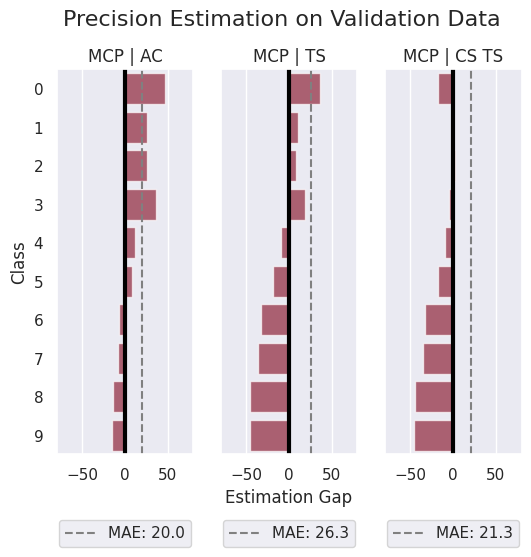

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(6, 5))  # Adjust figsize as needed
sns.set_theme(style="darkgrid")
#
sns.barplot(ax =axs[0],  x=estim_err_mcp, y=np.arange(len(estim_err_mcp)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[0].set_xlabel('')
# Add y-axis label
axs[0].set_ylabel('Class')
axs[0].set_title('MCP | AC')
mean_estim_err = np.mean(np.abs(estim_err_mcp))
axs[0].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[0].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[0].set_xlim(-80, 80)  # Adjust the range as needed
#
sns.barplot(ax =axs[1],  x=estim_err_ts, y=np.arange(len(estim_err_ts)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[1].set_xlabel('Estimation Gap')
# Add y-axis label
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('MCP | TS')
mean_estim_err = np.mean(np.abs(estim_err_ts))
axs[1].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[1].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[1].set_xlim(-80, 80)  # Adjust the range as needed
#
sns.barplot(ax =axs[2],  x=estim_err_csts, y=np.arange(len(estim_err_csts)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[2].set_xlabel('')
# Add y-axis label
axs[2].set_yticks([])
axs[2].set_ylabel('')
axs[2].set_title('MCP | CS TS')
mean_estim_err = np.mean(np.abs(estim_err_csts))
axs[2].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[2].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[2].set_xlim(-80, 80)  # Adjust the range as needed
#
fig.suptitle('Precision Estimation on Validation Data', fontsize=16, y=1.0)  # Adjust fontsize and y position as needed
plt.savefig(f'Fig_prec_val.pdf', bbox_inches='tight')
plt.show()

In [58]:
# MCP | AC
dataset = "CIFAR10"
mode = "classification"
metric = "precision"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ac-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
real_F1scores = []
for kcls in range(logits.shape[1]):
    _, real_Sensitivity, real_Precision = ComputMetric(gt_test == kcls, pred_test == kcls)
    real_F1scores.append(real_Precision)
real_metric_test = real_F1scores
#
estim_err_mcp_test = (estim_metric_test - real_metric_test) * 100
# MCP | TS
dataset = "CIFAR10"
mode = "classification"
metric = "precision"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
estim_err_ts_test = (estim_metric_test - real_metric_test) * 100
# MCP | CS TS
dataset = "CIFAR10"
mode = "classification"
metric = "precision"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = True
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
estim_err_csts_test = (estim_metric_test - real_metric_test) * 100

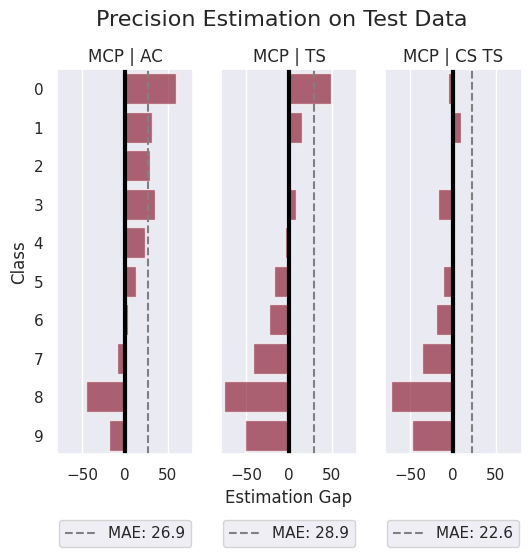

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(6, 5))  # Adjust figsize as needed
sns.set_theme(style="darkgrid")
#
sns.barplot(ax =axs[0],  x=estim_err_mcp_test, y=np.arange(len(estim_err_mcp_test)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[0].set_xlabel('')
# Add y-axis label
axs[0].set_ylabel('Class')
axs[0].set_title('MCP | AC')
mean_estim_err = np.mean(np.abs(estim_err_mcp_test))
axs[0].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[0].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[0].set_xlim(-80, 80)  # Adjust the range as needed
#
sns.barplot(ax =axs[1],  x=estim_err_ts_test, y=np.arange(len(estim_err_ts_test)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[1].set_xlabel('Estimation Gap')
# Add y-axis label
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('MCP | TS')
mean_estim_err = np.mean(np.abs(estim_err_ts_test))
axs[1].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[1].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[1].set_xlim(-80, 80)  # Adjust the range as needed
#
sns.barplot(ax =axs[2],  x=estim_err_csts_test, y=np.arange(len(estim_err_csts_test)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[2].set_xlabel('')
# Add y-axis label
axs[2].set_yticks([])
axs[2].set_ylabel('')
axs[2].set_title('MCP | CS TS')
mean_estim_err = np.mean(np.abs(estim_err_csts_test))
axs[2].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[2].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[2].set_xlim(-80, 80)  # Adjust the range as needed
#
fig.suptitle('Precision Estimation on Test Data', fontsize=16, y=1.0)  # Adjust fontsize and y position as needed
plt.savefig(f'Fig_prec_test.pdf', bbox_inches='tight')
plt.show()

In [60]:
# AUC

In [61]:
# validation dataset
val_data = "/well/win-fmrib-analysis/users/gqu790/moval/Robust-Skin-Lesion-Classification/cifar10results/baseline/predictions_val.csv"
# test dataset
test_data = "/well/win-fmrib-analysis/users/gqu790/moval/Robust-Skin-Lesion-Classification/cifar10results/baseline/predictions_val_defocus_blur.csv"
#
cnn_pred = pd.read_csv(val_data)
targets_all = np.array(cnn_pred[['target_0', 'target_1', 'target_2', 'target_3', 'target_4',
                                 'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits = np.array(cnn_pred[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4',
                               'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt = np.argmax(targets_all, axis = 1)
#
cnn_pred_test = pd.read_csv(test_data)
targets_all_test = np.array(cnn_pred_test[['target_0', 'target_1', 'target_2', 'target_3', 'target_4',
                                           'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits_test = np.array(cnn_pred_test[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4',
                                      'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt_test = np.argmax(targets_all_test, axis = 1)
pred_test = np.argmax(logits_test, axis = 1)

In [62]:
# MCP | AC
dataset = "CIFAR10"
mode = "classification"
metric = "auc"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ac-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
real_auc = ComputAUC(gt, cal_softmax(logits))
real_metric_val = real_auc
#
estim_err_mcp = (estim_metric_val - real_metric_val) * 100
# MCP | TS
dataset = "CIFAR10"
mode = "classification"
metric = "auc"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
estim_err_ts = (estim_metric_val - real_metric_val) * 100
# MCP | CS TS
dataset = "CIFAR10"
mode = "classification"
metric = "auc"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = True
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_val = moval_model.estimate(logits)
#
estim_err_csts = (estim_metric_val - real_metric_val) * 100

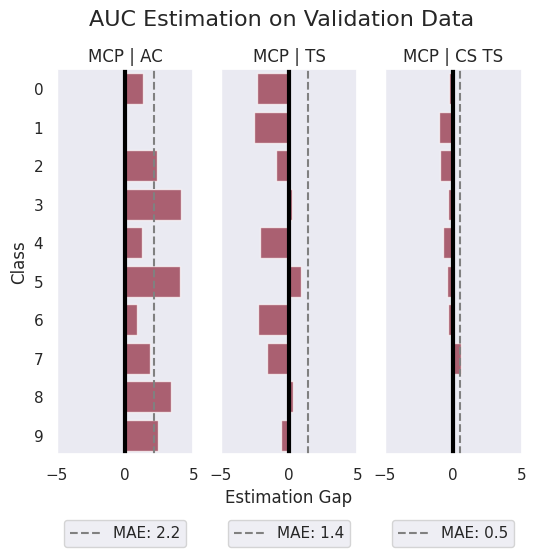

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(6, 5))  # Adjust figsize as needed
sns.set_theme(style="darkgrid")
#
sns.barplot(ax =axs[0],  x=estim_err_mcp, y=np.arange(len(estim_err_mcp)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[0].set_xlabel('')
# Add y-axis label
axs[0].set_ylabel('Class')
axs[0].set_title('MCP | AC')
mean_estim_err = np.mean(np.abs(estim_err_mcp))
axs[0].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[0].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[0].set_xlim(-5, 5)  # Adjust the range as needed
#
sns.barplot(ax =axs[1],  x=estim_err_ts, y=np.arange(len(estim_err_ts)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[1].set_xlabel('Estimation Gap')
# Add y-axis label
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('MCP | TS')
mean_estim_err = np.mean(np.abs(estim_err_ts))
axs[1].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[1].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[1].set_xlim(-5, 5)  # Adjust the range as needed
#
sns.barplot(ax =axs[2],  x=estim_err_csts, y=np.arange(len(estim_err_csts)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[2].set_xlabel('')
# Add y-axis label
axs[2].set_yticks([])
axs[2].set_ylabel('')
axs[2].set_title('MCP | CS TS')
mean_estim_err = np.mean(np.abs(estim_err_csts))
axs[2].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[2].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[2].set_xlim(-5, 5)  # Adjust the range as needed
#
fig.suptitle('AUC Estimation on Validation Data', fontsize=16, y=1.0)  # Adjust fontsize and y position as needed
plt.savefig(f'Fig_auc_val.pdf', bbox_inches='tight')
plt.show()

In [64]:
# MCP | AC
dataset = "CIFAR10"
mode = "classification"
metric = "auc"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ac-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
real_auc = ComputAUC(gt_test, cal_softmax(logits_test))
real_metric_test = real_auc
#
estim_err_mcp_test = (estim_metric_test - real_metric_test) * 100
# MCP | TS
dataset = "CIFAR10"
mode = "classification"
metric = "auc"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
estim_err_ts_test = (estim_metric_test - real_metric_test) * 100
# MCP | CS TS
dataset = "CIFAR10"
mode = "classification"
metric = "auc"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = True
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
#
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
estim_err_csts_test = (estim_metric_test - real_metric_test) * 100

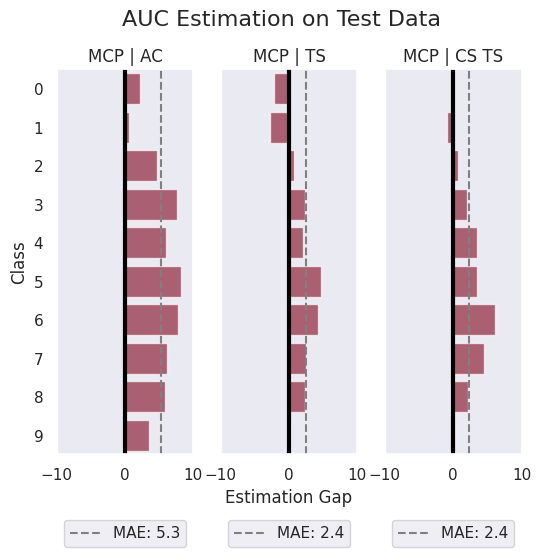

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(6, 5))  # Adjust figsize as needed
sns.set_theme(style="darkgrid")
#
sns.barplot(ax =axs[0],  x=estim_err_mcp_test, y=np.arange(len(estim_err_mcp_test)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[0].set_xlabel('')
# Add y-axis label
axs[0].set_ylabel('Class')
axs[0].set_title('MCP | AC')
mean_estim_err = np.mean(np.abs(estim_err_mcp_test))
axs[0].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[0].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[0].set_xlim(-10, 10)  # Adjust the range as needed
#
sns.barplot(ax =axs[1],  x=estim_err_ts_test, y=np.arange(len(estim_err_ts_test)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[1].set_xlabel('Estimation Gap')
# Add y-axis label
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('MCP | TS')
mean_estim_err = np.mean(np.abs(estim_err_ts_test))
axs[1].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[1].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[1].set_xlim(-10, 10)  # Adjust the range as needed
#
sns.barplot(ax =axs[2],  x=estim_err_csts_test, y=np.arange(len(estim_err_csts_test)), capsize=0.1, orient='h', color='#A2142F', alpha=0.7)
axs[2].set_xlabel('')
# Add y-axis label
axs[2].set_yticks([])
axs[2].set_ylabel('')
axs[2].set_title('MCP | CS TS')
mean_estim_err = np.mean(np.abs(estim_err_csts_test))
axs[2].axvline(x=mean_estim_err, color='grey', linestyle='--', label=f'MAE: {mean_estim_err:.1f}')
axs[2].axvline(x=0, color='black', linestyle='-', linewidth=3)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
# Set x-axis limits
axs[2].set_xlim(-10, 10)  # Adjust the range as needed
#
fig.suptitle('AUC Estimation on Test Data', fontsize=16, y=1.0)  # Adjust fontsize and y position as needed
plt.savefig(f'Fig_auc_test.pdf', bbox_inches='tight')
plt.show()

In [5]:
# Load skin lesion test logits, should be (N, 7)

In [298]:
def make_bar_plot(df, cls_acc, mean_conf, title = 'MCP Grouped by Predicted Class'):
    """Make the bar plot for the test case

    Args:
        df: The dataframe which contain all the information.
        cls_acc: A list of ``d`` mean accruacy.
        mean_conf: A list of ``d`` mean confidence.
        title: The given title to be shown.

    """

    # Set up the figure size and style
    sns.set(rc={'figure.figsize':(12,3)})
    sns.set_style("darkgrid")

    # Define the palette
    ax = sns.barplot(data=df, x="ID", y="Confidence Score", color = '#a52a2a',
                     order=df["ID"], width = 1)
    
    sns.barplot(data=df[df['Correctness']==True], x="ID", y="Confidence Score", color = '#0074b6',
                         order=df["ID"], width = 1)

    # # Set x-ticks to show every 10th group    
    samplelist = []
    for k in range(7):
        samplelist.append(np.sum(df['Prediction'] == k))
    
    x_ticks = []

    # Initialize the cumulative sum
    cumulative_sum = 0
    for i, value in enumerate(samplelist):
        cumulative_sum += value
        if i == 0:
            bin_center = value / 2
        else:
            bin_center = cumulative_sum - value / 2
        x_ticks.append(bin_center)

    x_ticks[-3] = x_ticks[-3] + 5
    
    ax.set(xticks=x_ticks[:-2], xticklabels=['nv', 'mel', 'bkl', 'bcc', 'akiec, etc'], xlabel="Predicted Class (Ordered from Majority to Minority)")

    # Move the legend to the upper left
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    blue_patch = mlines.Line2D([], [], color='#0074b6', label='Correct Prediction', linewidth=2)
    red_patch = mlines.Line2D([], [], color='#a52a2a', label='Wrong Prediction', linewidth=2)
    diff_patch = mpatches.Patch(color='#A2142F', alpha = 0.7, label='Estimation Gap')
    green_patch = mlines.Line2D([0.5, 0.5], [0, 1], color='black', lw=4, alpha=0.7, label='Mean Confidence')
    blank_patch = mpatches.Patch(color='black', alpha=0.7, edgecolor=None, label='Class-Wise Accuracy')
    
    plt.legend(handles=[blue_patch, red_patch, green_patch, blank_patch, diff_patch], 
               bbox_to_anchor=(0., -0.2), loc='upper left', ncols=5)

    ax.set_xlim(-2,220)

    ##########################################################################
    # Fill the area between (0, 0) and (10, 1)
    def plot_diff(ax, x_left, x_right, y_up, y_down, acc_all, mean_c):
        ax.fill_between([x_left, x_right], y_down, y_up, linewidth=0, edgecolor='none', facecolor='#A2142F', alpha=0.5)    
        ax.axhline(mean_c, xmin=(x_left+2)/222, xmax=(x_right+2)/222, color="black", lw=3, alpha=0.7, ls='-')
        # Create a hatched texture fill for the box with gradient color
        gradient_steps = 50  # Number of steps for the gradient
        for i in range(gradient_steps):
            # Calculate the gradient color at this step
            gradient_color = (1 - i / gradient_steps) * np.array([1, 1, 1]) + (i / gradient_steps) * np.array([0x00, 0x00, 0x00]) / 255
            facecolor = tuple(gradient_color)
            
            # Add a rectangle patch for this step
            x_start = (i / gradient_steps) * acc_all
            x_end = ((i + 1) / gradient_steps) * acc_all
            texture_box = patches.Rectangle((x_left, x_start), x_right - x_left, x_end - x_start, linewidth=0, edgecolor='none', facecolor=facecolor, alpha=0.5)
            ax.add_patch(texture_box)
    ## cls 0
    x_left = -0.75
    x_right = samplelist[0]-2.75
    y_up = np.max((cls_acc[0], mean_conf[0]))
    y_down = np.min((cls_acc[0], mean_conf[0]))
    acc_all = cls_acc[0]
    mean_c = mean_conf[0]
    plot_diff(ax, x_left, x_right, y_up, y_down, acc_all, mean_c)
    ## cls 1
    x_left = samplelist[0]-0.75
    x_right = samplelist[0]+samplelist[1]-2.75
    y_up = np.max((cls_acc[1], mean_conf[1]))
    y_down = np.min((cls_acc[1], mean_conf[1]))
    acc_all = cls_acc[1]
    mean_c = mean_conf[1]
    plot_diff(ax, x_left, x_right, y_up, y_down, acc_all, mean_c)
    ## cls 2
    x_left = samplelist[0]+samplelist[1]-0.75
    x_right = samplelist[0]+samplelist[1]+samplelist[2]-2.75
    y_up = np.max((cls_acc[2], mean_conf[2]))
    y_down = np.min((cls_acc[2], mean_conf[2]))
    acc_all = cls_acc[2]
    mean_c = mean_conf[2]
    plot_diff(ax, x_left, x_right, y_up, y_down, acc_all, mean_c)
    ## cls 3
    x_left = samplelist[0]+samplelist[1]+samplelist[2]-0.75
    x_right = samplelist[0]+samplelist[1]+samplelist[2]+samplelist[3]-2.75
    y_up = np.max((cls_acc[3], mean_conf[3]))
    y_down = np.min((cls_acc[3], mean_conf[3]))
    acc_all = cls_acc[3]
    mean_c = mean_conf[3]
    plot_diff(ax, x_left, x_right, y_up, y_down, acc_all, mean_c)
    ## cls 4
    x_left = samplelist[0]+samplelist[1]+samplelist[2]+samplelist[3]-0.75
    x_right = samplelist[0]+samplelist[1]+samplelist[2]+samplelist[3]+samplelist[4]-2.75
    y_up = np.max((cls_acc[4], mean_conf[4]))
    y_down = np.min((cls_acc[4], mean_conf[4]))
    acc_all = cls_acc[4]
    mean_c = mean_conf[4]
    plot_diff(ax, x_left, x_right, y_up, y_down, acc_all, mean_c)
    ## cls 5
    x_left = samplelist[0]+samplelist[1]+samplelist[2]+samplelist[3]+samplelist[4]-0.75
    x_right = samplelist[0]+samplelist[1]+samplelist[2]+samplelist[3]+samplelist[4]+samplelist[5]-2.75
    y_up = np.max((cls_acc[5], mean_conf[5]))
    y_down = np.min((cls_acc[5], mean_conf[5]))
    acc_all = cls_acc[5]
    mean_c = mean_conf[5]
    plot_diff(ax, x_left, x_right, y_up, y_down, acc_all, mean_c)
    ## cls 6
    x_left = samplelist[0]+samplelist[1]+samplelist[2]+samplelist[3]+samplelist[4]+samplelist[5]-0.75
    x_right = samplelist[0]+samplelist[1]+samplelist[2]+samplelist[3]+samplelist[4]+samplelist[5]+samplelist[6]-2.75
    y_up = np.max((cls_acc[6], mean_conf[6]))
    y_down = np.min((cls_acc[6], mean_conf[6]))
    acc_all = cls_acc[6]
    mean_c = mean_conf[6]
    plot_diff(ax, x_left, x_right, y_up, y_down, acc_all, mean_c)
    ##########################################################################
    
    plt.title(title)
    # Show the plot
    plt.savefig(f'Fig_{title}.pdf', bbox_inches='tight')
    plt.show()

In [299]:
def get_df_subset(df):
    """Get the subset of df with group-wise sampling, for visualization.

    Args:
        df: The dataframe which contain all the information.

    Returns:
        df_subset: The subsampled df.

    """

    # def random_sample(group, n=10):
    #     return group.sample(n, random_state=79)

    # # Apply the random_sample function to each group based on 'Prediction'
    # df_subset = df.groupby('Prediction', group_keys=False).apply(random_sample, n=10)
    #
    df_subset = df.sample(n=200, random_state=123, replace=True)
    df_subset.loc[df_subset['Confidence Score'] == 0, 'Confidence Score'] = 0.03 # show something for ATC calibrated

    print(f"Analyzing data with {len(df_subset)} samples")

    df_space_0 = {'Confidence Score': 0, 'ID': len(df) + 1, 'Ground Truth': 0, 'Prediction': 0, 'Correctness': True}
    df_space_1 = {'Confidence Score': 0, 'ID': len(df) + 2, 'Ground Truth': 1, 'Prediction': 1, 'Correctness': True}
    df_space_2 = {'Confidence Score': 0, 'ID': len(df) + 3, 'Ground Truth': 2, 'Prediction': 2, 'Correctness': True}
    df_space_3 = {'Confidence Score': 0, 'ID': len(df) + 4, 'Ground Truth': 3, 'Prediction': 3, 'Correctness': True}
    df_space_4 = {'Confidence Score': 0, 'ID': len(df) + 5, 'Ground Truth': 4, 'Prediction': 4, 'Correctness': True}
    df_space_5 = {'Confidence Score': 0, 'ID': len(df) + 6, 'Ground Truth': 5, 'Prediction': 5, 'Correctness': True}
    df_space_6 = {'Confidence Score': 0, 'ID': len(df) + 7, 'Ground Truth': 6, 'Prediction': 6, 'Correctness': True}
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_0])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_1])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_2])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_3])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_4])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_5])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_6])], ignore_index=True)
    #
    df_space_0 = {'Confidence Score': 0, 'ID': len(df) + 1, 'Ground Truth': 0, 'Prediction': 0, 'Correctness': True}
    df_space_1 = {'Confidence Score': 0, 'ID': len(df) + 2, 'Ground Truth': 1, 'Prediction': 1, 'Correctness': True}
    df_space_2 = {'Confidence Score': 0, 'ID': len(df) + 3, 'Ground Truth': 2, 'Prediction': 2, 'Correctness': True}
    df_space_3 = {'Confidence Score': 0, 'ID': len(df) + 4, 'Ground Truth': 3, 'Prediction': 3, 'Correctness': True}
    df_space_4 = {'Confidence Score': 0, 'ID': len(df) + 5, 'Ground Truth': 4, 'Prediction': 4, 'Correctness': True}
    df_space_5 = {'Confidence Score': 0, 'ID': len(df) + 6, 'Ground Truth': 5, 'Prediction': 5, 'Correctness': True}
    df_space_6 = {'Confidence Score': 0, 'ID': len(df) + 7, 'Ground Truth': 6, 'Prediction': 6, 'Correctness': True}
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_0])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_1])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_2])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_3])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_4])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_5])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_6])], ignore_index=True)
    #
    df_space_0 = {'Confidence Score': 0, 'ID': len(df) + 1, 'Ground Truth': 0, 'Prediction': 0, 'Correctness': True}
    df_space_1 = {'Confidence Score': 0, 'ID': len(df) + 2, 'Ground Truth': 1, 'Prediction': 1, 'Correctness': True}
    df_space_2 = {'Confidence Score': 0, 'ID': len(df) + 3, 'Ground Truth': 2, 'Prediction': 2, 'Correctness': True}
    df_space_3 = {'Confidence Score': 0, 'ID': len(df) + 4, 'Ground Truth': 3, 'Prediction': 3, 'Correctness': True}
    df_space_4 = {'Confidence Score': 0, 'ID': len(df) + 5, 'Ground Truth': 4, 'Prediction': 4, 'Correctness': True}
    df_space_5 = {'Confidence Score': 0, 'ID': len(df) + 6, 'Ground Truth': 5, 'Prediction': 5, 'Correctness': True}
    df_space_6 = {'Confidence Score': 0, 'ID': len(df) + 7, 'Ground Truth': 6, 'Prediction': 6, 'Correctness': True}
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_0])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_1])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_2])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_3])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_4])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_5])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_6])], ignore_index=True)
    #
    # First sorting by 'Prediction' in ascending order
    df_subset = df_subset.sort_values(by="Prediction", ascending=True, na_position='first')

    # Define a custom sorting key function
    def custom_sort(row):
        return row['Prediction'], -row['Confidence Score']  # Note the negative sign for descending order

    # Apply the custom sorting key function to the DataFrame
    df_subset['Sorting_Key'] = df_subset.apply(custom_sort, axis=1)
    df_subset = df_subset.sort_values(by='Sorting_Key')

    # Drop the temporary column
    df_subset = df_subset.drop(columns=['Sorting_Key'])

    return df_subset

In [300]:
# BCN dataset
testpath = "/well/win-fmrib-analysis/users/gqu790/moval/Robust-Skin-Lesion-Classification/skinresults/predictions_test_OTH.csv"

In [301]:
num_classes = 7
#
cnn_pred_test = pd.read_csv(testpath)
#
targets_all_test = np.array(cnn_pred_test[['target_' + str(i) for i in range(0, num_classes)]])
logits_test = np.array(cnn_pred_test[['logit_' + str(i) for i in range(0, num_classes)]])
gt_test = np.argmax(targets_all_test, axis = 1)

In [302]:
print(f"The test predictions, ``logits_test`` are of shape (n', d), which are now {logits_test.shape}")
print(f"The test labels, ``gt_test`` are of shape (n', ), which are now {gt_test.shape}")

The test predictions, ``logits_test`` are of shape (n', d), which are now (8201, 7)
The test labels, ``gt_test`` are of shape (n', ), which are now (8201,)


In [303]:
# MCP | AC
dataset = "HAM"
mode = "classification"
metric = "accuracy"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ac-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
pred_test = np.argmax(logits_test, axis = 1)
real_metric_test = np.sum(gt_test == pred_test) / len(gt_test)
#
print(estim_metric_test - real_metric_test)
#
conf_test = moval_model.model_.calibrate(logits_test)
#
Pred = np.argmax(logits_test, axis=1)
cls_index = {5:0, 4:1, 2:2, 1:3, 0:4, 6:5, 3:6}
#
d = {'Confidence Score': conf_test,
         'ID': range(len(conf_test)),
         'Ground Truth': gt_test,
         'Prediction': np.array([cls_index[idx] for idx in Pred]),
         'Correctness': gt_test == np.argmax(logits_test, axis=1)}
df = pd.DataFrame(data=d)
# change the index of predicted class.
#
cls_order = [5, 4, 2, 1, 0, 6, 3]
mean_conf = []
cls_acc = []
acc_all = np.sum(gt_test == np.argmax(logits_test, axis = 1)) / len(np.argmax(logits_test, axis = 1))
for k_cls in cls_order:

    k_pos = np.where(np.argmax(logits_test, axis=1) == k_cls)[0]
    #
    _logits = logits_test[k_pos, :]
    _gt = gt_test[k_pos]
    _conf = conf_test[k_pos]
    #
    mean_conf.append(np.mean(_conf))
    #
    acc = np.sum(_gt == np.argmax(_logits, axis = 1)) / len(np.argmax(_logits, axis = 1))
    cls_acc.append(acc)

0.2845699152067983


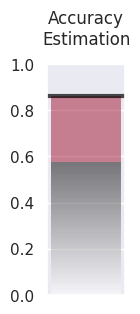

In [304]:
# show the overall perf
# _mean_conf
# acc_all
sns.set(rc={'figure.figsize':(1,3)})
sns.set_style("darkgrid")

_mean_conf = np.mean(conf_test)

x_left = 0
x_right = 1

ax = plt.gca()

y_down = np.min((_mean_conf, acc_all))
y_up = np.max((_mean_conf, acc_all))
ax.fill_between([x_left, x_right], y_down, y_up, linewidth=0, edgecolor='none', facecolor='#A2142F', alpha=0.5)    
# Create a hatched texture fill for the box with gradient color
gradient_steps = 50  # Number of steps for the gradient
for i in range(gradient_steps):
    # Calculate the gradient color at this step
    gradient_color = (1 - i / gradient_steps) * np.array([1, 1, 1]) + (i / gradient_steps) * np.array([0x00, 0x00, 0x00]) / 255
    facecolor = tuple(gradient_color)
    
    # Add a rectangle patch for this step
    x_start = (i / gradient_steps) * acc_all
    x_end = ((i + 1) / gradient_steps) * acc_all
    texture_box = patches.Rectangle((x_left, x_start), x_right - x_left, x_end - x_start, linewidth=0, edgecolor='none', facecolor=facecolor, alpha=0.5)
    ax.add_patch(texture_box)


plt.axhline(_mean_conf, color="black", lw=3, alpha=0.7, ls='-')

plt.ylim(0, 1)

# Remove x-axis ticks
plt.xticks([])

plt.title('Accuracy\nEstimation', y=1.05)  # Adjust fontsize and y position as needed
plt.savefig(f'Fig_mcp.pdf', bbox_inches='tight')

plt.show()

Analyzing data with 200 samples


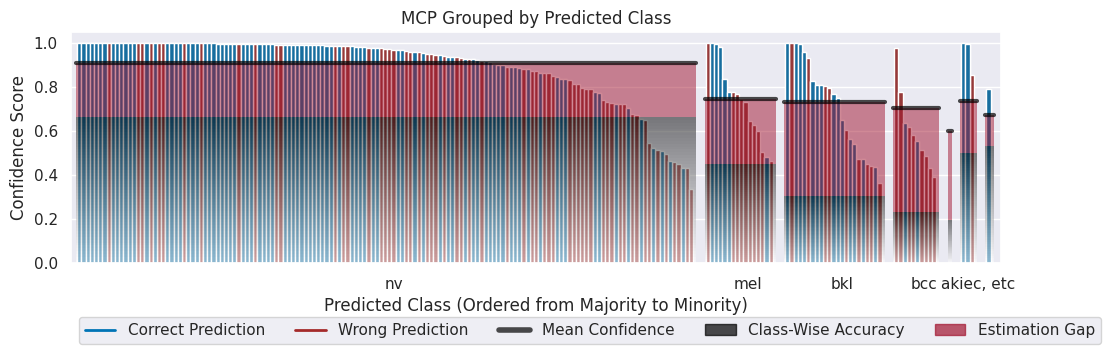

In [305]:
make_bar_plot(get_df_subset(df), cls_acc, mean_conf, title = 'MCP Grouped by Predicted Class')

In [306]:
# MCP | TS
dataset = "HAM"
mode = "classification"
metric = "accuracy"
confidence_scores = "max_class_probability-conf"
estim_algorithm = "ts-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
pred_test = np.argmax(logits_test, axis = 1)
real_metric_test = np.sum(gt_test == pred_test) / len(gt_test)
#
print(estim_metric_test - real_metric_test)
#
conf_test = moval_model.model_.calibrate(logits_test)
#
Pred = np.argmax(logits_test, axis=1)
cls_index = {5:0, 4:1, 2:2, 1:3, 0:4, 6:5, 3:6}
#
d = {'Confidence Score': conf_test,
         'ID': range(len(conf_test)),
         'Ground Truth': gt_test,
         'Prediction': np.array([cls_index[idx] for idx in Pred]),
         'Correctness': gt_test == np.argmax(logits_test, axis=1)}
df = pd.DataFrame(data=d)
#
cls_order = [5, 4, 2, 1, 0, 6, 3]
mean_conf = []
cls_acc = []
acc_all = np.sum(gt_test == np.argmax(logits_test, axis = 1)) / len(np.argmax(logits_test, axis = 1))
for k_cls in cls_order:

    k_pos = np.where(np.argmax(logits_test, axis=1) == k_cls)[0]
    #
    _logits = logits_test[k_pos, :]
    _gt = gt_test[k_pos]
    _conf = conf_test[k_pos]
    #
    mean_conf.append(np.mean(_conf))
    #
    acc = np.sum(_gt == np.argmax(_logits, axis = 1)) / len(np.argmax(_logits, axis = 1))
    cls_acc.append(acc)

0.15916483641468826


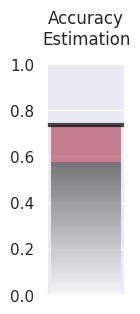

In [307]:
# show the overall perf
# _mean_conf
# acc_all
sns.set(rc={'figure.figsize':(1,3)})
sns.set_style("darkgrid")

_mean_conf = np.mean(conf_test)

x_left = 0
x_right = 1

ax = plt.gca()

y_down = np.min((_mean_conf, acc_all))
y_up = np.max((_mean_conf, acc_all))
ax.fill_between([x_left, x_right], y_down, y_up, linewidth=0, edgecolor='none', facecolor='#A2142F', alpha=0.5)    
# Create a hatched texture fill for the box with gradient color
gradient_steps = 50  # Number of steps for the gradient
for i in range(gradient_steps):
    # Calculate the gradient color at this step
    gradient_color = (1 - i / gradient_steps) * np.array([1, 1, 1]) + (i / gradient_steps) * np.array([0x00, 0x00, 0x00]) / 255
    facecolor = tuple(gradient_color)
    
    # Add a rectangle patch for this step
    x_start = (i / gradient_steps) * acc_all
    x_end = ((i + 1) / gradient_steps) * acc_all
    texture_box = patches.Rectangle((x_left, x_start), x_right - x_left, x_end - x_start, linewidth=0, edgecolor='none', facecolor=facecolor, alpha=0.5)
    ax.add_patch(texture_box)


plt.axhline(_mean_conf, color="black", lw=3, alpha=0.7, ls='-')

plt.ylim(0, 1)

# Remove x-axis ticks
plt.xticks([])

plt.title('Accuracy\nEstimation', y=1.05)  # Adjust fontsize and y position as needed
plt.savefig(f'Fig_ts.pdf', bbox_inches='tight')

plt.show()

Analyzing data with 200 samples


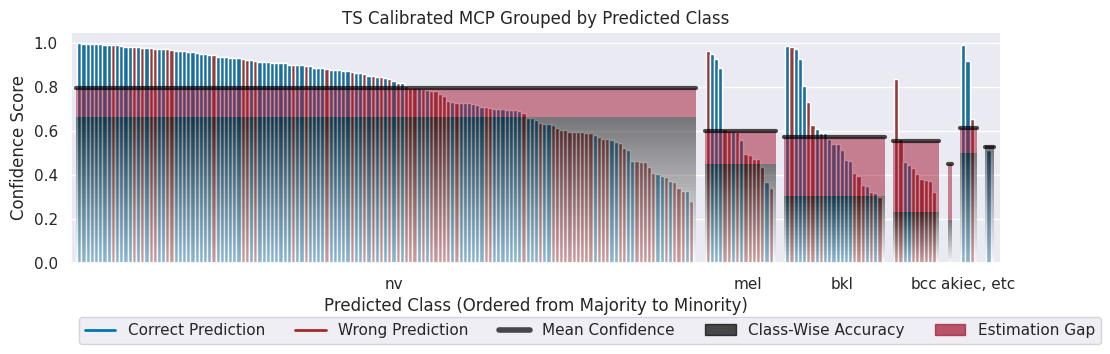

In [308]:
make_bar_plot(get_df_subset(df), cls_acc, mean_conf, title = 'TS Calibrated MCP Grouped by Predicted Class')

In [309]:
# Doctor | CS TS
dataset = "HAM"
mode = "classification"
metric = "accuracy"
confidence_scores = "doctor-conf"
estim_algorithm = "ts-model"
class_specific = False
ckpt_savname = f"./{dataset}_{mode}_{metric}_{confidence_scores}_{estim_algorithm}_{class_specific}.pkl"
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
pred_test = np.argmax(logits_test, axis = 1)
real_metric_test = np.sum(gt_test == pred_test) / len(gt_test)
#
print(estim_metric_test - real_metric_test)
#
conf_test = moval_model.model_.calibrate(logits_test)
#
Pred = np.argmax(logits_test, axis=1)
cls_index = {5:0, 4:1, 2:2, 1:3, 0:4, 6:5, 3:6}
#
d = {'Confidence Score': conf_test,
         'ID': range(len(conf_test)),
         'Ground Truth': gt_test,
         'Prediction': np.array([cls_index[idx] for idx in Pred]),
         'Correctness': gt_test == np.argmax(logits_test, axis=1)}
df = pd.DataFrame(data=d)
#
cls_order = [5, 4, 2, 1, 0, 6, 3]
mean_conf = []
cls_acc = []
acc_all = np.sum(gt_test == np.argmax(logits_test, axis = 1)) / len(np.argmax(logits_test, axis = 1))
for k_cls in cls_order:

    k_pos = np.where(np.argmax(logits_test, axis=1) == k_cls)[0]
    #
    _logits = logits_test[k_pos, :]
    _gt = gt_test[k_pos]
    _conf = conf_test[k_pos]
    #
    mean_conf.append(np.mean(_conf))
    #
    acc = np.sum(_gt == np.argmax(_logits, axis = 1)) / len(np.argmax(_logits, axis = 1))
    cls_acc.append(acc)

0.133982100425317


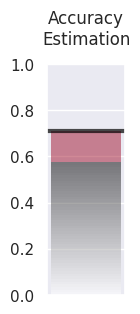

In [310]:
# show the overall perf
# _mean_conf
# acc_all
sns.set(rc={'figure.figsize':(1,3)})
sns.set_style("darkgrid")

_mean_conf = np.mean(conf_test)

x_left = 0
x_right = 1

ax = plt.gca()

y_down = np.min((_mean_conf, acc_all))
y_up = np.max((_mean_conf, acc_all))
ax.fill_between([x_left, x_right], y_down, y_up, linewidth=0, edgecolor='none', facecolor='#A2142F', alpha=0.5)    
# Create a hatched texture fill for the box with gradient color
gradient_steps = 50  # Number of steps for the gradient
for i in range(gradient_steps):
    # Calculate the gradient color at this step
    gradient_color = (1 - i / gradient_steps) * np.array([1, 1, 1]) + (i / gradient_steps) * np.array([0x00, 0x00, 0x00]) / 255
    facecolor = tuple(gradient_color)
    
    # Add a rectangle patch for this step
    x_start = (i / gradient_steps) * acc_all
    x_end = ((i + 1) / gradient_steps) * acc_all
    texture_box = patches.Rectangle((x_left, x_start), x_right - x_left, x_end - x_start, linewidth=0, edgecolor='none', facecolor=facecolor, alpha=0.5)
    ax.add_patch(texture_box)


plt.axhline(_mean_conf, color="black", lw=3, alpha=0.7, ls='-')

plt.ylim(0, 1)

# Remove x-axis ticks
plt.xticks([])

plt.title('Accuracy\nEstimation', y=1.05)  # Adjust fontsize and y position as needed
plt.savefig(f'Fig_doctor.pdf', bbox_inches='tight')

plt.show()

Analyzing data with 200 samples


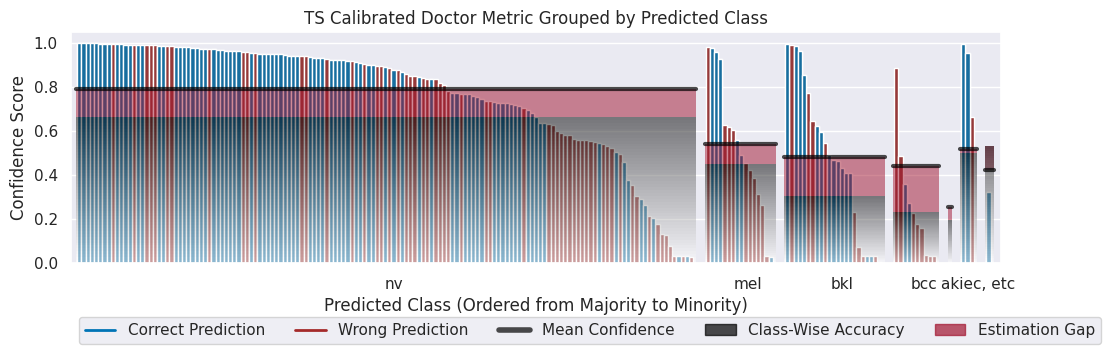

In [311]:
make_bar_plot(get_df_subset(df), cls_acc, mean_conf, title = 'TS Calibrated Doctor Metric Grouped by Predicted Class')

In [312]:
# MOVAL Ensemble
dataset = "HAM"
mode = "classification"
metric = "accuracy"
estim_algorithm = "moval-ensemble-cls-accuracy"
ckpt_savname = f"./{dataset}_{mode}_{metric}_{estim_algorithm}.pkl"
moval_model = moval.MOVAL.load(ckpt_savname)
#
estim_metric_test = moval_model.estimate(logits_test)
#
pred_test = np.argmax(logits_test, axis = 1)
real_metric_test = np.sum(gt_test == pred_test) / len(gt_test)
#
print(estim_metric_test - real_metric_test)
#
conf_test_0 = moval_model.model_[0].calibrate(logits_test)
conf_test_1 = moval_model.model_[1].calibrate(logits_test)
conf_test_2 = moval_model.model_[2].calibrate(logits_test)
conf_test = np.mean(np.stack((conf_test_0, conf_test_1, conf_test_2)), axis = 0)
#
Pred = np.argmax(logits_test, axis=1)
cls_index = {5:0, 4:1, 2:2, 1:3, 0:4, 6:5, 3:6}
#
d = {'Confidence Score': conf_test,
         'ID': range(len(conf_test)),
         'Ground Truth': gt_test,
         'Prediction': np.array([cls_index[idx] for idx in Pred]),
         'Correctness': gt_test == np.argmax(logits_test, axis=1)}
df = pd.DataFrame(data=d)
#
cls_order = [5, 4, 2, 1, 0, 6, 3]
mean_conf = []
cls_acc = []
acc_all = np.sum(gt_test == np.argmax(logits_test, axis = 1)) / len(np.argmax(logits_test, axis = 1))
for k_cls in cls_order:

    k_pos = np.where(np.argmax(logits_test, axis=1) == k_cls)[0]
    #
    _logits = logits_test[k_pos, :]
    _gt = gt_test[k_pos]
    _conf = conf_test[k_pos]
    #
    mean_conf.append(np.mean(_conf))
    #
    acc = np.sum(_gt == np.argmax(_logits, axis = 1)) / len(np.argmax(_logits, axis = 1))
    cls_acc.append(acc)

0.06767467382026582


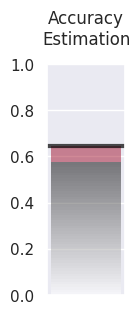

In [313]:
# show the overall perf
# _mean_conf
# acc_all
sns.set(rc={'figure.figsize':(1,3)})
sns.set_style("darkgrid")

_mean_conf = np.mean(conf_test)

x_left = 0
x_right = 1

ax = plt.gca()

y_down = np.min((_mean_conf, acc_all))
y_up = np.max((_mean_conf, acc_all))
ax.fill_between([x_left, x_right], y_down, y_up, linewidth=0, edgecolor='none', facecolor='#A2142F', alpha=0.5)    
# Create a hatched texture fill for the box with gradient color
gradient_steps = 50  # Number of steps for the gradient
for i in range(gradient_steps):
    # Calculate the gradient color at this step
    gradient_color = (1 - i / gradient_steps) * np.array([1, 1, 1]) + (i / gradient_steps) * np.array([0x00, 0x00, 0x00]) / 255
    facecolor = tuple(gradient_color)
    
    # Add a rectangle patch for this step
    x_start = (i / gradient_steps) * acc_all
    x_end = ((i + 1) / gradient_steps) * acc_all
    texture_box = patches.Rectangle((x_left, x_start), x_right - x_left, x_end - x_start, linewidth=0, edgecolor='none', facecolor=facecolor, alpha=0.5)
    ax.add_patch(texture_box)


plt.axhline(_mean_conf, color="black", lw=3, alpha=0.7, ls='-')

plt.ylim(0, 1)

# Remove x-axis ticks
plt.xticks([])

plt.title('Accuracy\nEstimation', y=1.05)  # Adjust fontsize and y position as needed
plt.savefig(f'Fig_moval.pdf', bbox_inches='tight')

plt.show()

Analyzing data with 200 samples


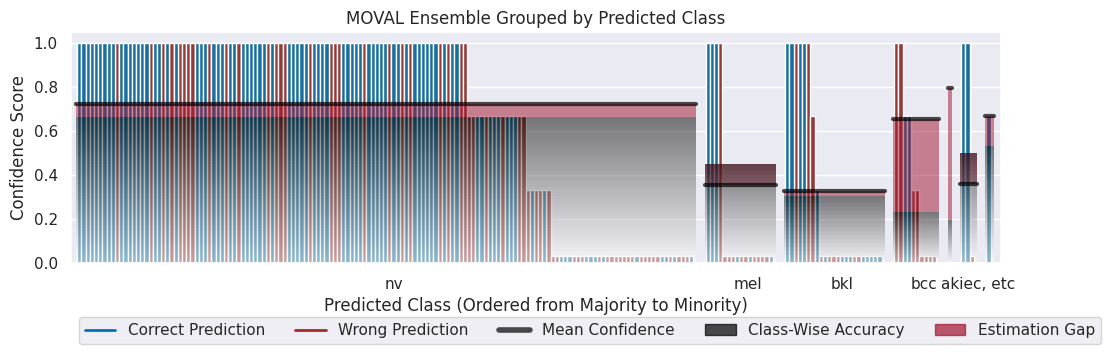

In [314]:
make_bar_plot(get_df_subset(df), cls_acc, mean_conf, title = 'MOVAL Ensemble Grouped by Predicted Class')